Is the same as *Radon_analysis* notebook but used for specific plots for **The NEXT-100 Detector** paper.

OJO! Recientemente he realizado variaciones con respecto a la forma que realizo los fits. Para corroborar, ver la versión oficial en *Radon_analysis*.

In [10]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis/libs')

import crudo
import fit_functions as ff
from   iminuit import Minuit                    # type: ignore
from   iminuit.cost import LeastSquares         # type: ignore
import matplotlib.pyplot as plt                 # type: ignore
import numpy as np
import pickle
import plotting_tools as pt
from   scipy.optimize import curve_fit

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Styling Plot
pt.auto_plot_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminary

In [2]:
# α runs!
runs_info = [
                # # Jan 2025
                # {"run_number": 14714, "duration": 64527, "OK": -1     , "LOST": -1     , "real_rate": -1    },
                # {"run_number": 14715, "duration": 84365, "OK": 2469062, "LOST": 2239303, "real_rate": 55.809},  # NO processed
                # {"run_number": 14716, "duration": 17036, "OK": 495769 , "LOST": 451306 , "real_rate": 55.592},
                # {"run_number": 14720, "duration": 48518, "OK": -1     , "LOST": -1     , "real_rate": -1    },
                # {"run_number": 14733, "duration": 53881, "OK": 1587637, "LOST": 1429629, "real_rate": 55.998},
                # {"run_number": 14735, "duration": 84987, "OK": 2508569, "LOST": 2267982, "real_rate": 56.203},
                # {"run_number": 14737, "duration": 72705, "OK": 2153786, "LOST": 1960347, "real_rate": 56.586},
                {"run_number": 14739, "duration": 87138, "OK": 2576630, "LOST": 2334343, "real_rate": 56.358},
                # {"run_number": 14741, "duration": 87755, "OK": 2592615, "LOST": 2349583, "real_rate": 56.318},
                # {"run_number": 14743, "duration": 82332, "OK": 2437984, "LOST": 2220643, "real_rate": 56.583},
                # {"run_number": 14745, "duration": 60990, "OK": 1803415, "LOST": 1636317, "real_rate": 56.398},
                # # --- NO Cold Getter: Jan 27 --- #
                # {"run_number": 14753, "duration": 86308, "OK": 2188547, "LOST": 1532351, "real_rate": 43.111},
                # {"run_number": 14765, "duration": 55978, "OK": 1259832, "LOST": 735202 , "real_rate": 35.639},
                # {"run_number": 14776, "duration": 47397, "OK": 957081 , "LOST": 481810 , "real_rate": 30.358},  # Data removed
                # {"run_number": 14780, "duration": 88503, "OK": 1600797, "LOST": 682246 , "real_rate": 25.796},
                # # Feb 2025
                # {"run_number": 14782, "duration": 85654, "OK": 1382153, "LOST": 506234 , "real_rate": 22.046},
                # {"run_number": 14784, "duration": 57290, "OK": 842541 , "LOST": 273581 , "real_rate": 19.481},
                # {"run_number": 14789, "duration": 74148, "OK": 976360 , "LOST": 277504 , "real_rate": 16.910},
                # # --- Zero Suppression --- #
                # {"run_number": 14803, "duration": 71721, "OK": 933727 , "LOST": 104677 , "real_rate": 14.478},
                # {"run_number": 14804, "duration": 65116, "OK": 680552 , "LOST": 156995 , "real_rate": 12.862},
                # # --- NO Zero Suppression --- #
                # {"run_number": 14811, "duration": -1   , "OK": -1     , "LOST": -1     , "real_rate": -1    },
                # {"run_number": 14814, "duration": 6344 , "OK": 55679  , "LOST": 10155  , "real_rate": 10.377},
                # {"run_number": 14815, "duration": 86232, "OK": 717786 , "LOST": 121527 , "real_rate": 9.733 },
                # {"run_number": 14816, "duration": 86580, "OK": 659265 , "LOST": 101374 , "real_rate": 8.785 },
                # {"run_number": 14817, "duration": 49662, "OK": 352203 , "LOST": 50474  , "real_rate": 8.108 },  
                # {"run_number": 14828, "duration": 53609, "OK": 300827 , "LOST": 100405 , "real_rate": 7.484 },
                # {"run_number": 14829, "duration": 73042, "OK": 387003 , "LOST": 121249 , "real_rate": 6.958 },
                # {"run_number": 14834, "duration": 5779 , "OK": 32864  , "LOST": 3887   , "real_rate": 6.359 },
                # {"run_number": 14835, "duration": 11713, "OK": 66515  , "LOST": 7358   , "real_rate": 6.306 },
                # {"run_number": 14837, "duration": 55751, "OK": 294175 , "LOST": 31034  , "real_rate": 5.833 },
                # {"run_number": 14838, "duration": 87854, "OK": 431766 , "LOST": 42219  , "real_rate": 5.395 },
                # {"run_number": 14839, "duration": 84881, "OK": 401004 , "LOST": 37747  , "real_rate": 5.169 },
                # {"run_number": 14840, "duration": 55363, "OK": 260266 , "LOST": 22528  , "real_rate": 5.108 },  # Elog malfunction: estimated values
            ]

## Reconstructed Data

In [3]:
raw_data = {run["run_number"]: crudo.load_run_data(run, trigger=None)[run["run_number"]] for run in runs_info}

/DST/Events: Run 14739 successfully loaded with data shape: (403582, 26)


### Efficiency

Compute the efficiency of reconstructed events (after Sophronia) wrt the number of OK triggers

In [4]:
for i, entry in enumerate(runs_info):

    # Run info
    run_id = entry["run_number"]
    run_OK = entry["OK"]

    # Skip runs without empty raw data
    if raw_data[run_id].empty:
        print(f"Run {run_id}: No raw data available")
        continue

    # Number of reconstructed events (after Sophronia)
    reco_evt_CV  = raw_data[run_id]['event'].nunique()         if run_OK != -1 else -1
    reco_eff     = reco_evt_CV / run_OK                        if run_OK != -1 else -1
    reco_evt_err = np.sqrt(run_OK * reco_eff * (1 - reco_eff)) if run_OK != -1 else -1

    # Store and print information
    runs_info[i]["reco_evt_CV"]  = reco_evt_CV
    runs_info[i]["reco_evt_err"] = reco_evt_err
    print(f"Run {run_id}: ({reco_evt_CV} ± {reco_evt_err:.2f}) reconstructed events || ({reco_eff:.2%})")

Run 14739: (339737 ± 543.09) reconstructed events || (13.19%)


## Selected Data

Compute the efficiency of selected events wrt the number of reconstructed events.

In [6]:
# Dataframe name
df_name = 'alpha_runs'

# Open the file with selected data
with open(f"/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/pkl/{df_name}.pkl", "rb") as file:
    sel_data = pickle.load(file)
            
# This is the number of events you work with
for i, entry in enumerate(runs_info):

    # Run info
    run_id = entry["run_number"]
    run_OK = entry["OK"]

    # Skip runs without empty raw data
    if raw_data[run_id].empty:
        print(f"Run {run_id}: No raw data available")
        continue

    # Number of selected events
    reco_evt_CV = raw_data[run_id]['event'].nunique()            if run_OK != -1 else -1
    sel_evt_CV  = sel_data[run_id]['event'].nunique()            if run_OK != -1 else -1
    sel_eff     = sel_evt_CV / reco_evt_CV                       if run_OK != -1 else -1
    sel_evt_err = np.sqrt(reco_evt_CV * sel_eff * (1 - sel_eff)) if run_OK != -1 else -1

    # Store and print information
    runs_info[i]["sel_evt_CV"]  = sel_evt_CV
    runs_info[i]["sel_evt_err"] = sel_evt_err
    print(f"Run {run_id}: ({sel_evt_CV} ± {sel_evt_err:.2f}) selected events || ({sel_eff:.2%})")

Run 14739: (72721 ± 239.07) selected events || (21.41%)


## Extra

#### Exclusion dictionaries due to lack of information

In [7]:
# They have not yet been processed
NO_data = {
            14715: "NO processed",
            14776: "Data removed",
          }

# They do not have all the ELOG information
NO_elog = {
            14714: "NO elog information",
            14720: "NO elog information",
            14811: "NO elog information",
          }
NO_elog = {**NO_data, **NO_elog}

# They have problems with the reconstruction
NO_reco = {
            14716: "Glowing?",
            14720: "Glowing?",
            14765: "Glowing?",
          }
NO_reco = {**NO_elog, **NO_reco}

#### Active volume and cathode surroundings masks!

In [8]:
# Dictionaries with masks!
DT_stop   = {run["run_number"]: {} for run in runs_info}
AV_mask   = {run["run_number"]: {} for run in runs_info}
cath_mask = {run["run_number"]: {} for run in runs_info}

for i, entry in enumerate(runs_info):

    # Run info
    run_id   = entry["run_number"]
    run_rate = entry["real_rate"]
    
    # Skip runs without elog information.
    if run_id in NO_elog:  
        print(f"Skipping run {run_id}: {NO_elog[run_id]}")  
        continue

    # Time mask
    DT_stop[run_id] = crudo.cathode_position(entry, sel_data, step_back=1)[run_id]
    # Active volume
    AV_mask[run_id] = (sel_data[run_id]['DT'] >= 0) & (sel_data[run_id]['DT'] < DT_stop[run_id])
    # Cathode surroundings
    cath_mask[run_id] = sel_data[run_id]['DT'] >= DT_stop[run_id]

Run 14739: DT_stop = 1319.83 μs


# Fits
To fit data we just use the population of the detector's center, where the information is quite uniform.

In [9]:
# Store fits information
fit_parameters = {run["run_number"]: {} for run in runs_info}

## $S2e$ vs DT: Lifetime

--- Analyzing Run 14739 ---

Initial guess: N0 = 828202.7262 PE, tau = 450.2828 μs
--- HESSE ---
  N0 = (831674.39 ± 635.50) PE, τ = (56.54 ± 2.76) ms
--- MINOS --- 
N0 = 831674.39 PE || -636.43, 634.84
τ  = 56.54 ms || -2.63, 2.91
χ² / ndof = 1.6141



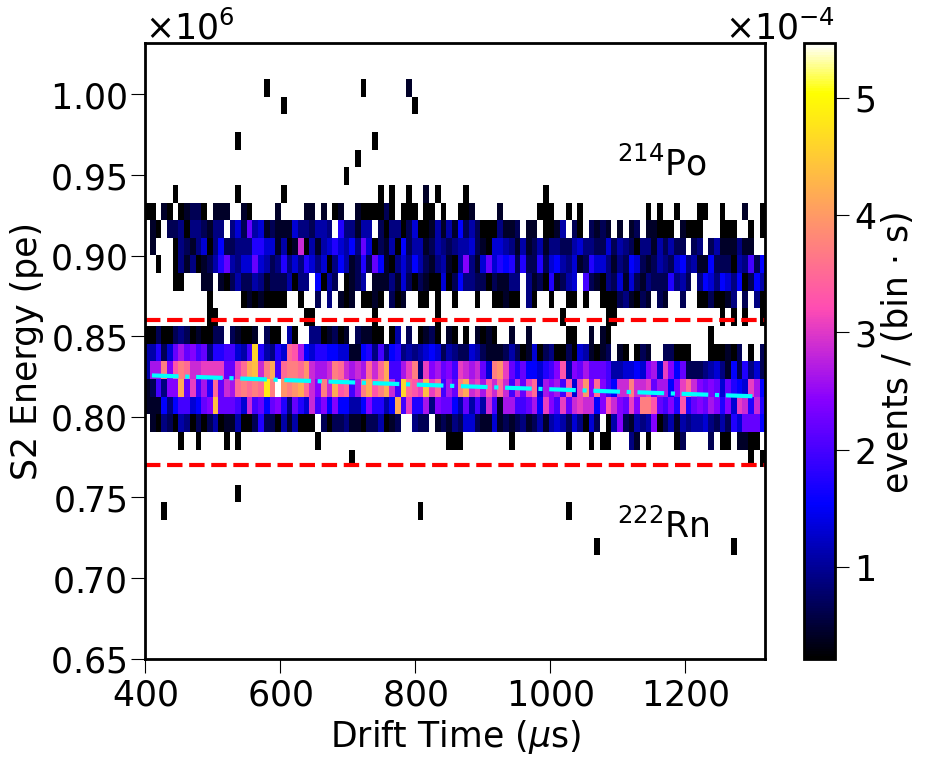

In [20]:
# Global
rad_lim = 200
n_bins  = 200

# Use exponential decay function with b = 0
def exp_bfixed(x, N0, tau):
    return ff.exponential_decay(x, N0, tau, 0)

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]    
    run_DAQe = (entry["OK"] / (entry["OK"] + entry["LOST"]))

    print(f"--- Analyzing Run {run_id} ---")
    
    # Skip runs without elog information.
    if run_id in NO_elog:  
        print(f"Skipping run {run_id}: {NO_elog[run_id]}")  
        continue
        
    # Variables    
    E2 = sel_data[run_id]['S2e']
    DT = sel_data[run_id]['DT']
    R  = sel_data[run_id]['R']

    # Masking
    rad_mask = (R <= rad_lim)
    E2_mask  = E2[AV_mask[run_id] & rad_mask]
    DT_mask  = DT[AV_mask[run_id] & rad_mask]

    # 2D histogram: normalized by corrected DAQ data taking time
    S2e_DT_map, ex, ey = pt.hist_2D(DT_mask, E2_mask, x_bins=150, y_bins=200)
    S2e_DT_map         = S2e_DT_map / (run_long * run_DAQe)                           
    S2e_DT_map         = np.ma.masked_where(S2e_DT_map==0, S2e_DT_map)                # Zero values masked
    # S2e_DT_map = np.clip(S2e_DT_map, 0, 50)                                           # Clipped values in colorbar

    # ---- Exponential Fit ----- #
    # Preliminary
    DT_down = 400;    DT_up = DT_mask.max()
    E2_down = 770e3;  E2_up = 860e3

    # Filter the data for the fit
    fit_region_mask = (DT_mask >= DT_down) & (DT_mask <= DT_up) & \
                      (E2_mask >= E2_down) & (E2_mask <= E2_up)
    DT_fit = DT_mask[fit_region_mask]
    E2_fit = E2_mask[fit_region_mask]

    DT_centers, _, S2e_means, S2e_means_err = ff.prefit_2D(DT_fit, E2_fit, bins=50)

    # Filter out points with zero error (bins with 1 event)
    valid_points = S2e_means_err > 0
    DT_centers   = DT_centers[valid_points]
    S2e_means     = S2e_means[valid_points]
    S2e_means_err = S2e_means_err[valid_points]

    # Fit
    # Definte the cost function + initial guess
    least_squares = LeastSquares(DT_centers, S2e_means, S2e_means_err, exp_bfixed)
    # Initial guess
    init_guess = [S2e_means.max(), (DT_centers.max() - DT_centers.min()) / 2]
    print(f'\nInitial guess: N0 = {init_guess[0]:.4f} PE, tau = {init_guess[1]:.4f} μs')

    # Define the Minuit object
    m = Minuit(least_squares, *init_guess)
    m.limits["N0", "tau"] = (0, None)               # Ensure N0 and tau are positive

    # Minimization process of the cost function and error estimation
    m.migrad()
    m.hesse()
    m.minos()

    # Results
    # HESSE
    popt_hesse = m.values;  perr_hesse = m.errors
    print(f'--- HESSE ---\n  N0 = ({popt_hesse[0]:.2f} ± {perr_hesse[0]:.2f}) PE, τ = ({popt_hesse[1] / 1e3:.2f} ± {perr_hesse[1] / 1e3:.2f}) ms')
    fit_parameters[run_id]["S2e"] = {"N0_CV": popt_hesse[0], "N0_err": perr_hesse[0], "tau_CV": popt_hesse[1], "tau_err": perr_hesse[1]}

    # MINOS (best-fit values are the same)
    popt_minos = m.values;  merr_minos = m.merrors
    print(f'--- MINOS --- \nN0 = {popt_minos["N0"]:.2f} PE || {merr_minos["N0"].lower:.2f}, {merr_minos["N0"].upper:.2f}')
    print(f'τ  = {popt_minos["tau"] / 1e3:.2f} ms || {merr_minos["tau"].lower / 1e3:.2f}, {merr_minos["tau"].upper / 1e3:.2f}')

    # Reduced chi-square
    chi2 = m.fval
    ndof = len(DT_centers) - m.nfit
    print(f"χ² / ndof = {chi2 / ndof:.4f}\n")
    
    # ----- Plotting ----- #

    # Data
    plt.pcolormesh(ex, ey, S2e_DT_map.T, shading='auto')
    cbar = plt.colorbar(label='events / (bin · s)', shrink=1.0)
    # cbar.set_label('Rate (Hz)', fontsize=18)
    # cbar.ax.tick_params(labelsize=16)
    # cbar.formatter.set_powerlimits((-3, -3))
    # cbar.locator = plt.MaxNLocator(nbins=8)  # Display more ticks
    cbar.update_ticks()

    # Fit
    fit_y = exp_bfixed(DT_centers, *popt_hesse)
    # # plt.errorbar(DT_centers, S2e_means, yerr=S2e_means_err, 
    #              fmt='o', color='green', ecolor='lightcoral', markersize=5, capsize=2, label='Profile (Media y Error)')
    # plt.scatter(DT_centers, S2e_medians, c='green', alpha=0.75, s=25)
    plt.plot(DT_centers, fit_y, c='cyan', ls='-.')

    plt.axhline(y=E2_up, c='red', ls='--')
    plt.axhline(y=E2_down, c='red', ls='--')

    # ----- Styling ----- #
    plt.xlabel('Drift Time ($\mu$s)')
    plt.xlim(400, DT_mask.max())
    plt.ylabel('S2 Energy (pe)')
    plt.ylim(650e3, 1.2*E2_up)
    plt.ticklabel_format(axis='y', style='sci')
    # plt.title(f'Run {run_id}: AV & (R <= {rad_lim} mm)')

    plt.text(1100, 0.725e6, r'$^{222}$Rn', color='black')
    plt.text(1100, 0.95e6, r'$^{214}$Po', color='black')

    # plt.gca().set_facecolor("whitesmoke")
    # plt.grid(True)
    # plt.savefig(f'/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/temp/LT_fit_run{run_id}.pdf')
    plt.show() 


Initial guess: N0 = 828202.7262 PE, tau = 450.2828 μs
Run 14739 fit: N0 = 831674.39 ± 635.50 PE, τ = 56.54 ± 2.76 ms
χ² / ndof = 1.6141



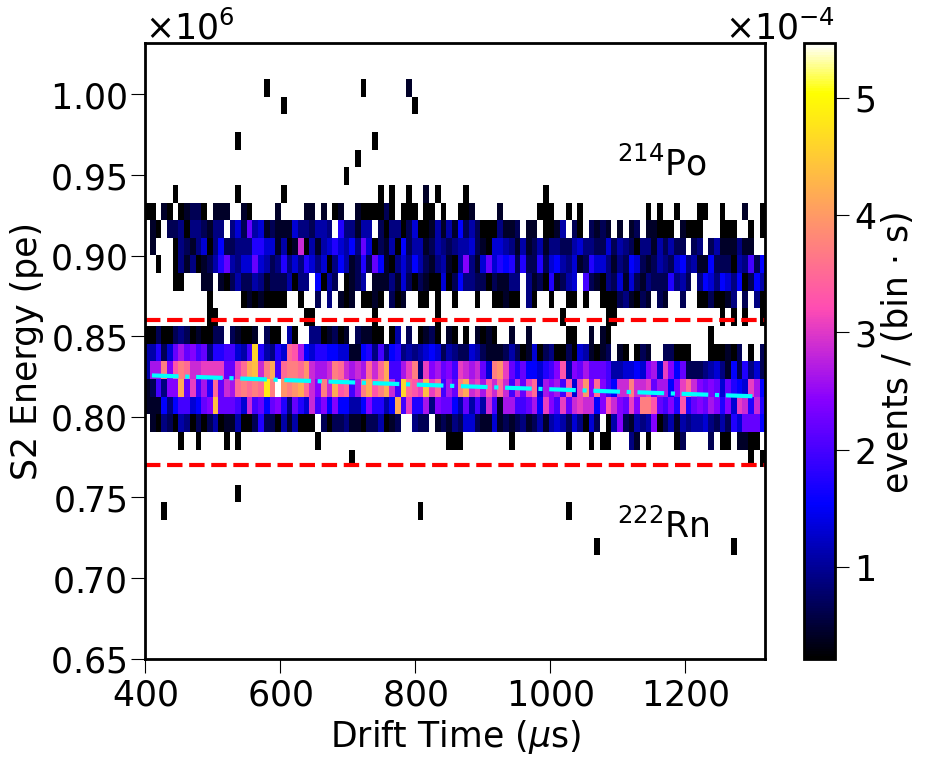

In [ ]:
# Global
rad_lim = 200
n_bins  = 200

# Use exponential decay function with b = 0
def exp_bfixed(x, N0, tau):
    return ff.exponential_decay(x, N0, tau, 0)

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]    
    run_DAQe = (entry["OK"] / (entry["OK"] + entry["LOST"]))
    
    # Skip runs without elog information.
    if run_id in NO_elog:  
        print(f"Skipping run {run_id}: {NO_elog[run_id]}")  
        continue
        
    # Variables    
    E2 = sel_data[run_id]['S2e']
    DT = sel_data[run_id]['DT']
    R  = sel_data[run_id]['R']

    # Masking
    rad_mask = (R <= rad_lim)
    E2_mask  = E2[AV_mask[run_id] & rad_mask]
    DT_mask  = DT[AV_mask[run_id] & rad_mask]

    # 2D histogram: normalized by corrected DAQ data taking time
    S2e_DT_map, ex, ey = pt.hist_2D(DT_mask, E2_mask, x_bins=150, y_bins=200)
    S2e_DT_map         = S2e_DT_map / (run_long * run_DAQe)                           
    S2e_DT_map         = np.ma.masked_where(S2e_DT_map==0, S2e_DT_map)                # Zero values masked
    # S2e_DT_map = np.clip(S2e_DT_map, 0, 50)                                           # Clipped values in colorbar

    # ---- Exponential Fit ----- #
    # Preliminary
    DT_down = 400;    DT_up = DT_mask.max()
    E2_down = 770e3;  E2_up = 860e3
    if run_id in {14803, 14804, 14814, 14815, 14816, 14817, 14828}:
        DT_down = 300;    DT_up = DT_mask.max()
        E2_down = 685e3;  E2_up = 765e3
    elif run_id in {14829, 14834, 14835, 14837, 14838, 14839, 14840}:
        DT_down = 250;    DT_up = DT_mask.max()
        E2_down = 870e3;  E2_up = 950e3

    # Filter the data for the fit
    fit_region_mask = (DT_mask >= DT_down) & (DT_mask <= DT_up) & \
                      (E2_mask >= E2_down) & (E2_mask <= E2_up)
    DT_fit = DT_mask[fit_region_mask]
    E2_fit = E2_mask[fit_region_mask]

    DT_centers, _, S2e_means, S2e_means_err = ff.prefit_2D(DT_fit, E2_fit, bins=50)

    # DT_centers, S2e_medians, _ = ff.prefit_2D(ex, DT_mask, E2_mask, 
    #                                         x_min=DT_down, x_max=DT_up, y_min=E2_down, y_max=E2_up)

    # Filtrar puntos donde el error es cero (bines con 1 solo evento)
    valid_points = S2e_means_err > 0
    DT_centers   = DT_centers[valid_points]
    S2e_means     = S2e_means[valid_points]
    S2e_means_err = S2e_means_err[valid_points]

    # Fit
    # Definte the cost function + initial guess
    least_squares = LeastSquares(DT_centers, S2e_means, S2e_means_err, exp_bfixed)
    # Initial guess
    init_guess = [S2e_means.max(), (DT_centers.max() - DT_centers.min()) / 2]
    print(f'\nInitial guess: N0 = {init_guess[0]:.4f} PE, tau = {init_guess[1]:.4f} μs')

    # Define the Minuit object
    m = Minuit(least_squares, *init_guess)
    m.limits["N0", "tau"] = (0, None)  # Ensure N0 and tau are positive

    # Minimization process of the cost function and error estimation
    m.migrad()
    m.hesse()

    # Results
    popt = m.values;  perr = m.errors
    print(f'Run {run_id} fit: N0 = {popt[0]:.2f} ± {perr[0]:.2f} PE, τ = {popt[1] / 1e3:.2f} ± {perr[1] / 1e3:.2f} ms')
    fit_parameters[run_id]["S2e"] = {"N0_CV": popt[0], "N0_err": perr[0], "tau_CV": popt[1], "tau_err": perr[1]}

    # Reduced chi-square
    chi2 = m.fval
    ndof = len(DT_centers) - m.nfit
    print(f"χ² / ndof = {chi2 / ndof:.4f}\n")
    
    # ----- Plotting ----- #

    # Data
    plt.pcolormesh(ex, ey, S2e_DT_map.T, shading='auto')
    cbar = plt.colorbar(label='events / (bin · s)', shrink=1.0)
    # cbar.set_label('Rate (Hz)', fontsize=18)
    # cbar.ax.tick_params(labelsize=16)
    # cbar.formatter.set_powerlimits((-3, -3))
    # cbar.locator = plt.MaxNLocator(nbins=8)  # Display more ticks
    cbar.update_ticks()

    # Fit
    fit_y = exp_bfixed(DT_centers, *popt)
    # # plt.errorbar(DT_centers, S2e_means, yerr=S2e_means_err, 
    #              fmt='o', color='green', ecolor='lightcoral', markersize=5, capsize=2, label='Profile (Media y Error)')
    # plt.scatter(DT_centers, S2e_medians, c='green', alpha=0.75, s=25)
    plt.plot(DT_centers, fit_y, c='cyan', ls='-.')

    plt.axhline(y=E2_up, c='red', ls='--')
    plt.axhline(y=E2_down, c='red', ls='--')

    # Styling
    plt.xlabel('Drift Time ($\mu$s)')
    plt.xlim(400, DT_mask.max())
    plt.ylabel('S2 Energy (pe)')
    plt.ylim(650e3, 1.2*E2_up)
    plt.ticklabel_format(axis='y', style='sci')
    # plt.title(f'Run {run_id}: AV & (R <= {rad_lim} mm)')

    plt.text(1100, 0.725e6, r'$^{222}$Rn', color='black')
    plt.text(1100, 0.95e6, r'$^{214}$Po', color='black')

    # plt.gca().set_facecolor("whitesmoke")
    # plt.grid(True)
    # plt.savefig(f'/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/temp/LT_fit_run{run_id}.pdf')
    plt.show() 

# Energy Corrections

We perform energy corrections exclusively for the runs categorized as:

- **High $^{222}\text{Rn }\rightarrow$** 14739

In [31]:
# Global
run_ref = 14739  # Reference run for energy map corrections
n_bins  = 50

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id = entry["run_number"]
    
    # Analysis runs
    if run_id in {14739, 14829, 14837, 14838, 14839, 14840}:
        
        if run_id in {14739}:

            # Fit parameters for energy corrections
            CV_fit = [fit_parameters[run_id]['S1e']['m_CV'],  fit_parameters[run_id]['S1e']['b_CV']]
            LT_fit = [fit_parameters[run_id]['S2e']['N0_CV'], fit_parameters[run_id]['S2e']['tau_CV']]

            # Apply corrections
            sel_data[run_id] = crudo.correct_S1e   (sel_data[run_id], CV_fit, DT_stop[run_id], output_column='S1e_corr')  # S1 energy
            sel_data[run_id] = crudo.correct_S2e_LT(sel_data[run_id], LT_fit, output_column='S2e_corr_LT')                # S2 energy by lifetime

            # Generate the reference (High-Rn) energy map
            print(f"Generating energy map of reference...\nThank you run {run_id} for your stats")

            # Variables
            X_ref  = sel_data[run_id]['X']
            Y_ref  = sel_data[run_id]['Y']
            E2_ref = sel_data[run_id]['S2e_corr_LT']

            # Generate the energy map normalized to the center
            ref_energy_map, x_edges, y_edges = pt.mapping(X_ref[AV_mask[run_id]], Y_ref[AV_mask[run_id]], wei=E2_ref[AV_mask[run_id]], 
                                                          xy_bins=n_bins, norm=True)

        if run_id in {14829, 14837, 14838, 14839, 14840}:

            # Fit parameters for energy corrections
            CV_fit = [fit_parameters[run_id]['S1e']['m_CV'],  fit_parameters[run_id]['S1e']['b_CV']]
            LT_fit = [fit_parameters[run_id]['S2e']['N0_CV'], LT_lowRn]

            # Apply corrections
            sel_data[run_id] = crudo.correct_S1e   (sel_data[run_id], CV_fit, DT_stop[run_id], output_column='S1e_corr')  # S1 energy
            sel_data[run_id] = crudo.correct_S2e_LT(sel_data[run_id], LT_fit, output_column='S2e_corr_LT')                # S2 energy by lifetime

        print(f"Processing run {run_id}...")

        # Apply S2 energy correction by geometric map
        sel_data[run_id] = crudo.correct_S2e_map_fixed(sel_data[run_id], ref_energy_map, x_edges, y_edges)

Generating energy map of reference...
Thank you run 14739 for your stats
Processing run 14739...


### S1 Energy Corrected?

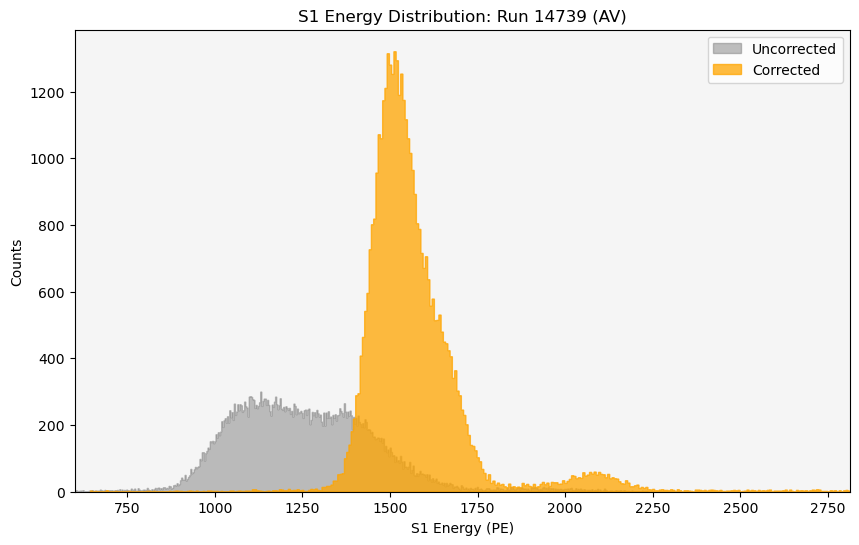

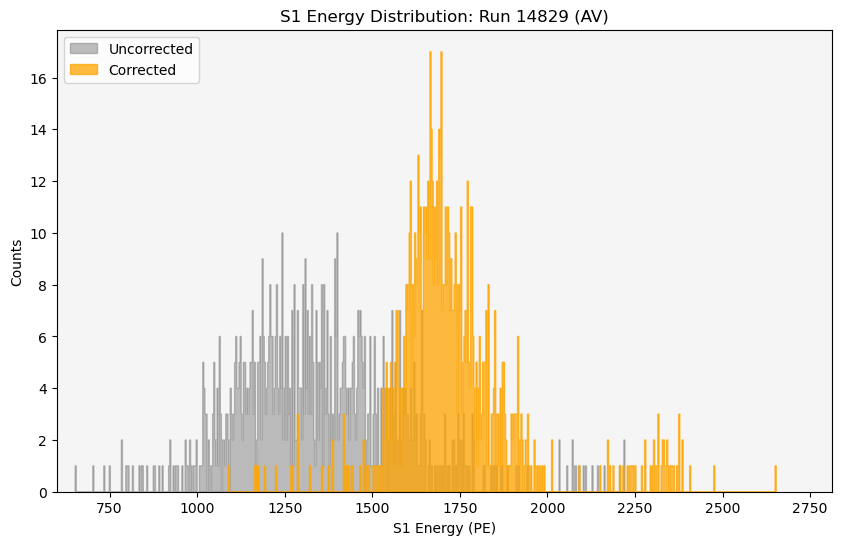

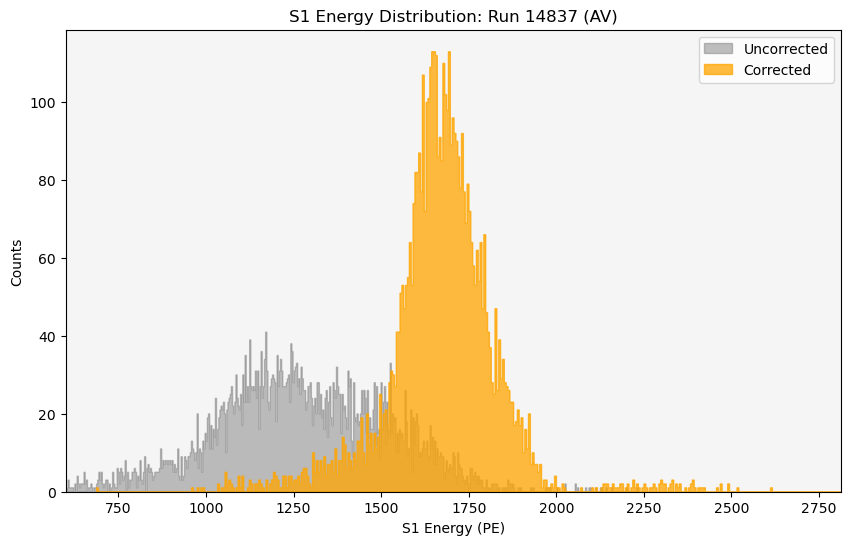

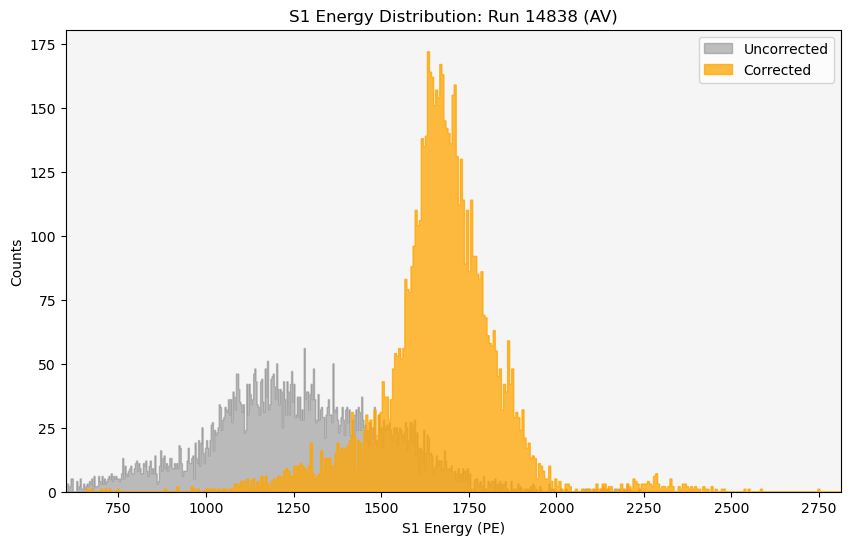

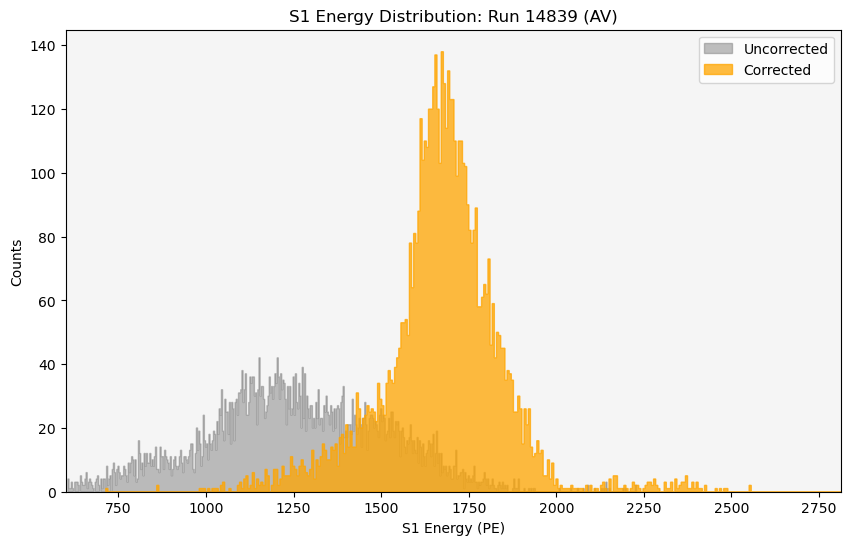

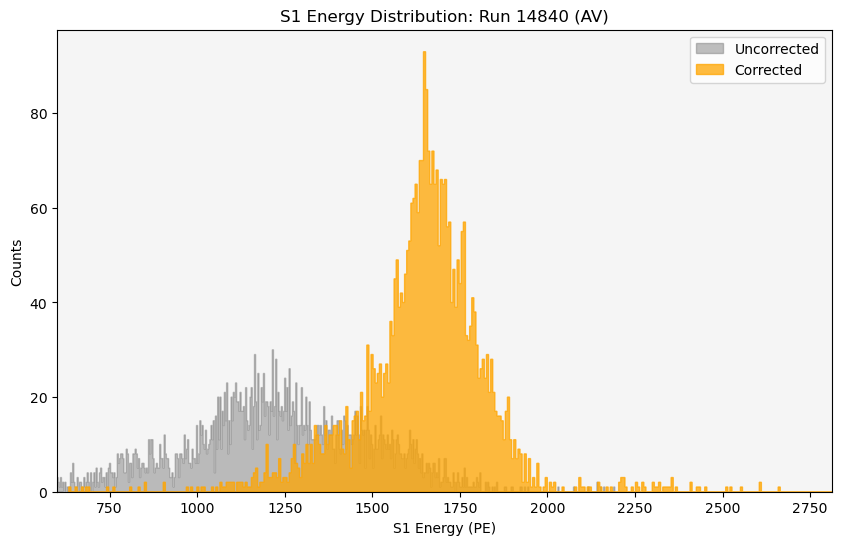

In [18]:
# Global
n_bins = 500

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    # Analysis runs
    if run_id in {14739, 14829, 14837, 14838, 14839, 14840}:
    
        # Variables    
        E1      = sel_data[run_id]['S1e']
        E1_corr = sel_data[run_id]['S1e_corr']

        # Masking
        E1_mask   = E1[AV_mask[run_id]]
        E1c_mask  = E1_corr[AV_mask[run_id]]

        # Limits
        E1_min = 800;  E1_max = 2250

        # Plot
        plt.figure(figsize=(10, 6))
        plt.hist(E1_mask, bins=n_bins, histtype='stepfilled', color='grey', alpha=0.50, ec='grey', label='Uncorrected')
        plt.hist(E1c_mask, bins=n_bins,  histtype='stepfilled', color='orange', alpha=0.75, ec='orange', label='Corrected')
        plt.xlim(0.75*E1_min, 1.25*E1_max)
        # plt.xlim(600, 2200)
        plt.xlabel('S1 Energy (PE)')
        plt.ylabel('Counts')
        # plt.ticklabel_format(axis='x', style='sci', scilimits=(3,3))
        plt.title(f'S1 Energy Distribution: Run {run_id} (AV)')
        plt.legend()

        plt.gca().set_facecolor('whitesmoke')
        # plt.grid(True)
        # plt.savefig(f'images/analysis/E1_corrected_run{run_id}.png', bbox_inches='tight')
        plt.show()

### S2 Energy Corrected?

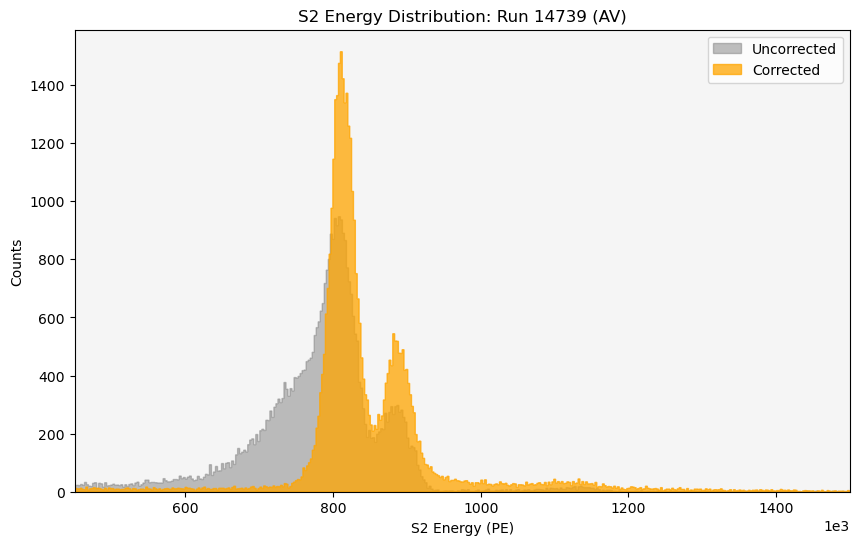

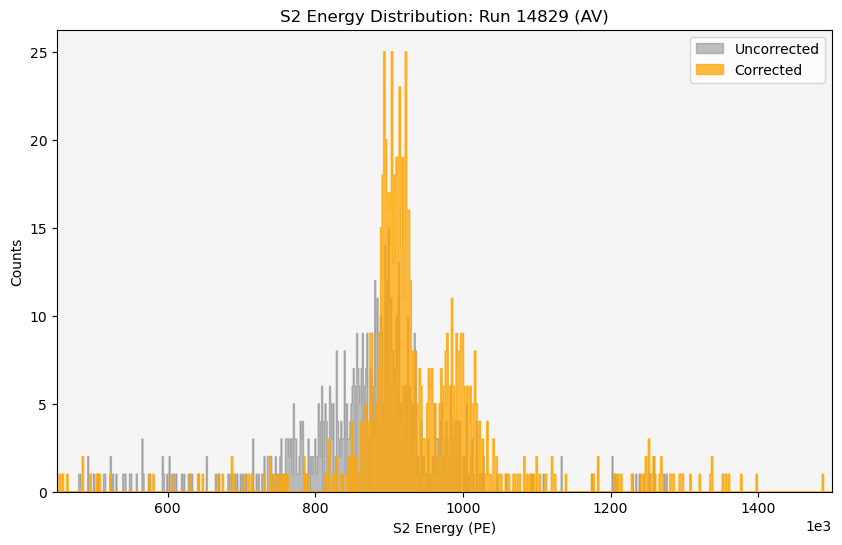

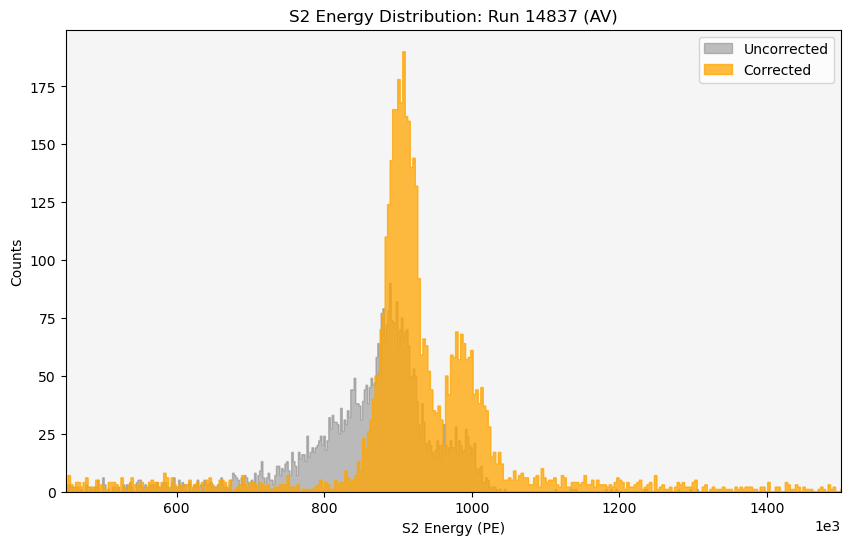

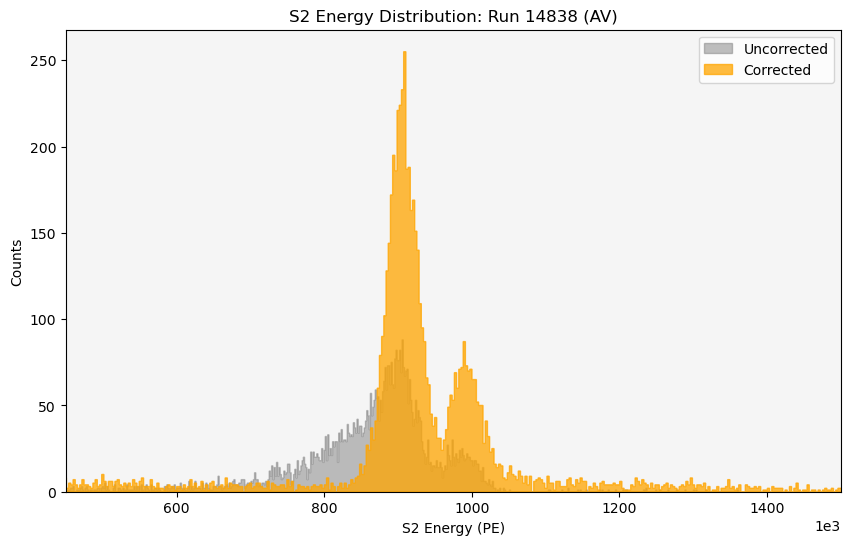

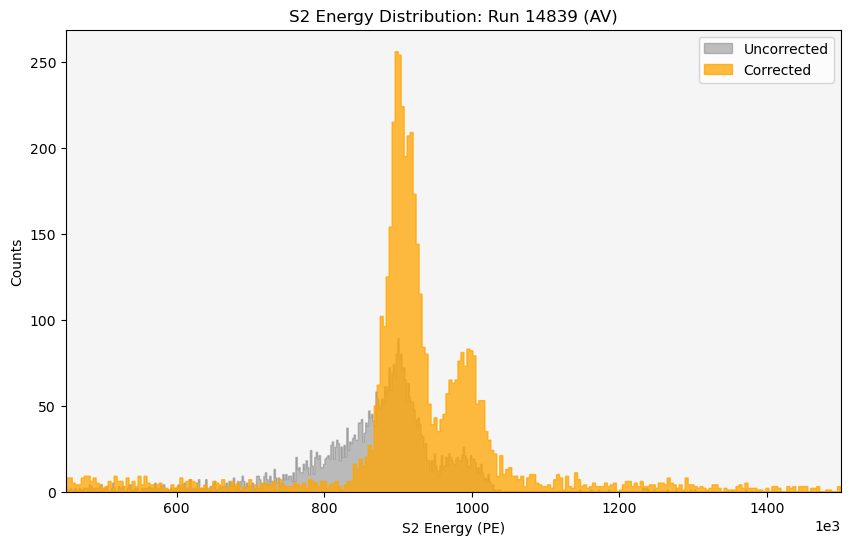

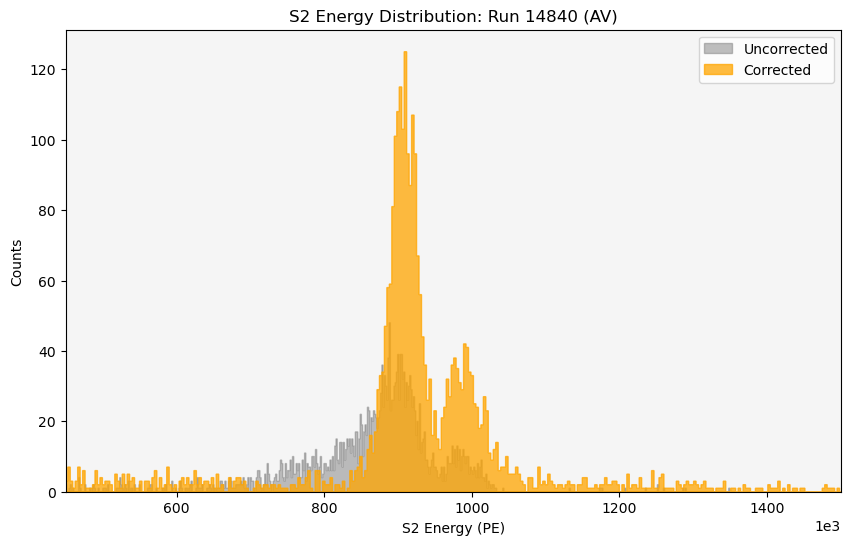

In [19]:
# Global
n_bins  = 800

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    # Analysis runs
    if run_id in {14739, 14829, 14837, 14838, 14839, 14840}:
    
        # Variables    
        E2      = sel_data[run_id]['S2e']
        E2_corr = sel_data[run_id]['S2e_corr']

        # Masking
        E2_mask   = E2[AV_mask[run_id]]
        E_mask  = E2_corr[AV_mask[run_id]]

        # Limits
        E2_min = 600e3;  E2_max = 1200e3

        # Plot
        plt.figure(figsize=(10, 6))
        plt.hist(E2_mask, bins=n_bins, histtype='stepfilled', color='grey', alpha=0.50, ec='grey', label='Uncorrected')
        plt.hist(E_mask, bins=n_bins,  histtype='stepfilled', color='orange', alpha=0.75, ec='orange', label='Corrected')
        plt.xlim(0.75*E2_min, 1.25*E2_max)
        plt.xlabel('S2 Energy (PE)')
        plt.ylabel('Counts')
        plt.ticklabel_format(axis='x', style='sci', scilimits=(3,3))
        plt.title(f'S2 Energy Distribution: Run {run_id} (AV)')
        plt.legend()

        plt.gca().set_facecolor('whitesmoke')
        #plt.grid(True)
        #plt.savefig(f'images/analysis/E2_corrected_run{run_id}.png', bbox_inches='tight')
        plt.show()

# High-Rn

### Trigger Efficiency
Not all the OK triggers correspond to alpha events.
<br>
Pau estimated the percentage of these triggers that are alphas through a discrimination in the $S1$ pulse.

In [36]:
# Global
ana_data = {
                'High-Rn': {}, 
                # 'Low-Rn' : {}
           }

# Trigger count efficiency (not all the triggers mean alphas events) ---> numbers given by Pau!
High_trigg_eff = 0.7542
Low_trigg_eff  = 0.3056
Err_trigg_eff  = 0.1

dfs = []          # To store the low-Rn dataframes
# Low-Rn values: CV + error calculations
low_long = 0
low_trigg_CV = 0;  low_trigg_err = 0
low_reco_CV  = 0;  low_reco_err  = 0
low_sel_CV   = 0;  low_sel_err   = 0

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]

    if run_id in NO_elog:
        continue
    
    run_long = entry["duration"]    
    run_OK   = entry["OK"] 
    run_LOST = entry["LOST"]
    reco_evt = entry["reco_evt_CV"]
    reco_err = entry["reco_evt_err"]
    sel_evt  = entry["sel_evt_CV"]
    sel_err  = entry["sel_evt_err"]
    
    if run_id in {14739}:

        # DAQe efficiency + error
        DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
        
        ana_data['High-Rn']['df']            = sel_data[run_id]
        ana_data['High-Rn']['duration_CV']   = run_long * DAQe_CV
        ana_data['High-Rn']['trigg_evt_CV']  = run_OK * High_trigg_eff
        ana_data['High-Rn']['trigg_evt_err'] = run_OK * High_trigg_eff * np.sqrt((np.sqrt(run_OK) / run_OK)**2 + (Err_trigg_eff / High_trigg_eff)**2)
        ana_data['High-Rn']['reco_evt_CV']   = reco_evt
        ana_data['High-Rn']['reco_evt_err']  = reco_err
        ana_data['High-Rn']['sel_evt_CV']    = sel_evt
        ana_data['High-Rn']['sel_evt_err']   = sel_err

#     if run_id in {14829, 14837, 14838, 14839, 14840}:

#         # DAQe efficiency + error
#         DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
        
#         dfs.append(sel_data[run_id])
#         low_long     += run_long * DAQe_CV
#         low_trigg_CV += run_OK * Low_trigg_eff;  low_trigg_err += low_trigg_CV**2 * ((np.sqrt(run_OK) / run_OK)**2 + (Err_trigg_eff / Low_trigg_eff)**2)
#         low_reco_CV  += reco_evt;                low_reco_err  += reco_err**2
#         low_sel_CV   += sel_evt;                 low_sel_err   += sel_err**2
    
# ana_data['Low-Rn']['df']           = pd.concat(dfs, ignore_index=True)
# ana_data['Low-Rn']['duration_CV']  = low_long
# ana_data['Low-Rn']['trigg_evt_CV'] = low_trigg_CV
# ana_data['Low-Rn']['trigg_evt_err'] = np.sqrt(low_trigg_err)
# ana_data['Low-Rn']['reco_evt_CV']  = low_reco_CV
# ana_data['Low-Rn']['reco_evt_err'] = np.sqrt(low_reco_err)
# ana_data['Low-Rn']['sel_evt_CV']   = low_sel_CV
# ana_data['Low-Rn']['sel_evt_err']  = np.sqrt(low_sel_err)

#### Masking again!

In [37]:
# Global
n_bins = 80
step_back = 2  # To avoid completely the cathode

for i, entry in enumerate(ana_data):
    
    Rn_data = ana_data[entry]['df']
    
    # Variables
    DT = Rn_data['DT']
    # Compute histogram avoiding negative values of DT (just in case)
    counts, bins = np.histogram(DT, bins=n_bins, range=(0, DT.max()))
    # Find the index of the bin with the highest count (cathode peak)
    cath_index = np.argmax(counts)
    
    # Ensure step_back is valid
    if cath_index - step_back < 0:
        raise ValueError(f"Warning: Invalid step back for {entry}.")
    else:
        # Compute DT_stop by stepping back from the cathode peak
        ana_data[entry]['DTstop_CV']  = (bins[cath_index - step_back] + bins[cath_index - step_back + 1]) / 2
        ana_data[entry]['DTstop_err'] = (bins[cath_index - step_back + 1] - bins[cath_index - step_back]) / 2
        
    print(f"{entry}: \n DT stop = ({ana_data[entry]['DTstop_CV']:.2f} ± {ana_data[entry]['DTstop_err']:.2f}) μs")
    
    # Active volume
    ana_data[entry]['AV_mask']   = (DT >= 0) & (DT <  ana_data[entry]['DTstop_CV'])
    # Cathode surroundings
    ana_data[entry]['cath_mask'] = DT >=  ana_data[entry]['DTstop_CV']

High-Rn: 
 DT stop = (1310.67 ± 9.17) μs


# Energy Estimator

We need to determine the optimum weight factor $\eta$ and the scale factor $\lambda$ for the new energy estimator using the $S1$ and $S2$ energy values.

In [38]:
# Here we store the selected parameters for the new energy estimator
Best_eta    = 0
High_lambda = 0
Low_lambda  = 0

## $\eta$ determination

Because of statistics, we use the High-Rn run 14739.

Run 14739 - Initial values: [2000, 1500.0, 4.278827791350738, 50, 2000.0, 4.278827791350738]
Run 14739 - Final values: [ 596.01373994 1509.01523478   56.00885967  211.43492705 1643.87699547
  -61.42303512]
Run 14739 - Energy resolution: 8.7409%


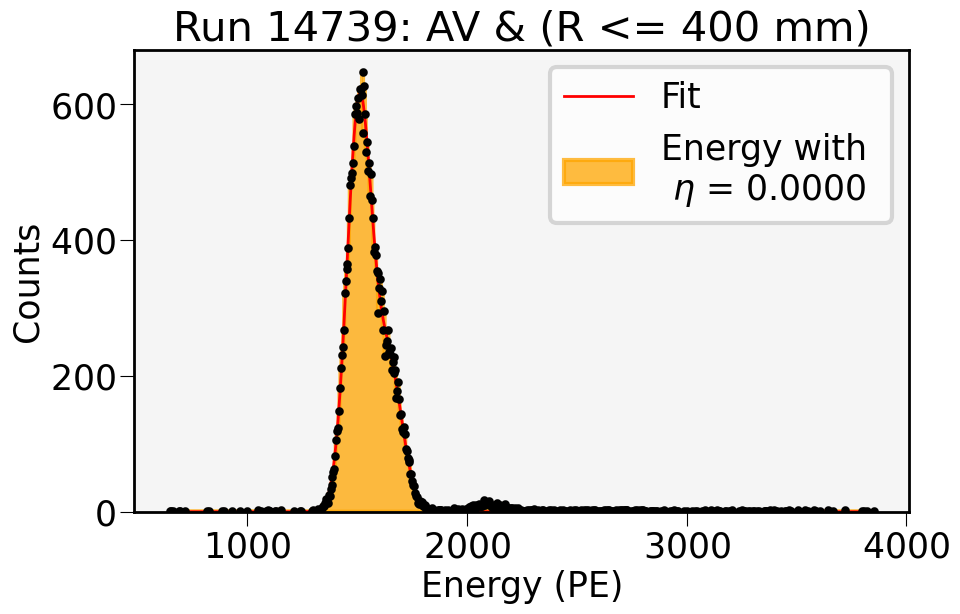

Run 14739 - Initial values: [2000, 1923.4693877551022, 4.792543911607549, 50, 2474.4897959183672, 4.792543911607549]
Run 14739 - Final values: [ 688.48553064 1923.31855666   54.30230703  238.83826724 2097.22705368
  -60.1102019 ]
Run 14739 - Energy resolution: 6.6490%


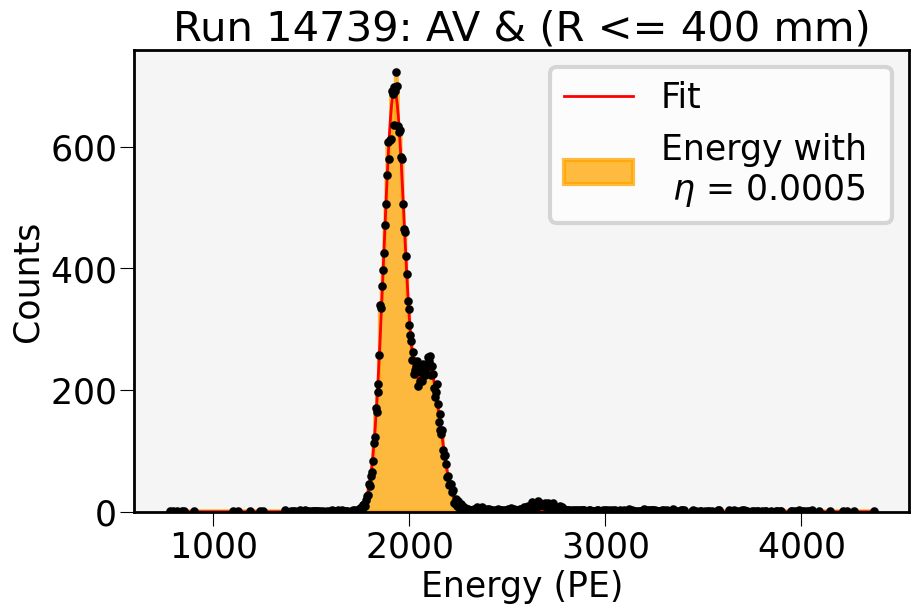

Run 14739 - Initial values: [2000, 2346.9387755102043, 5.412022762704541, 50, 2948.979591836735, 5.412022762704541]
Run 14739 - Final values: [ 774.82150581 2337.91941546   54.87457051  264.51788692 2550.45316117
   59.90451461]
Run 14739 - Energy resolution: 5.5275%


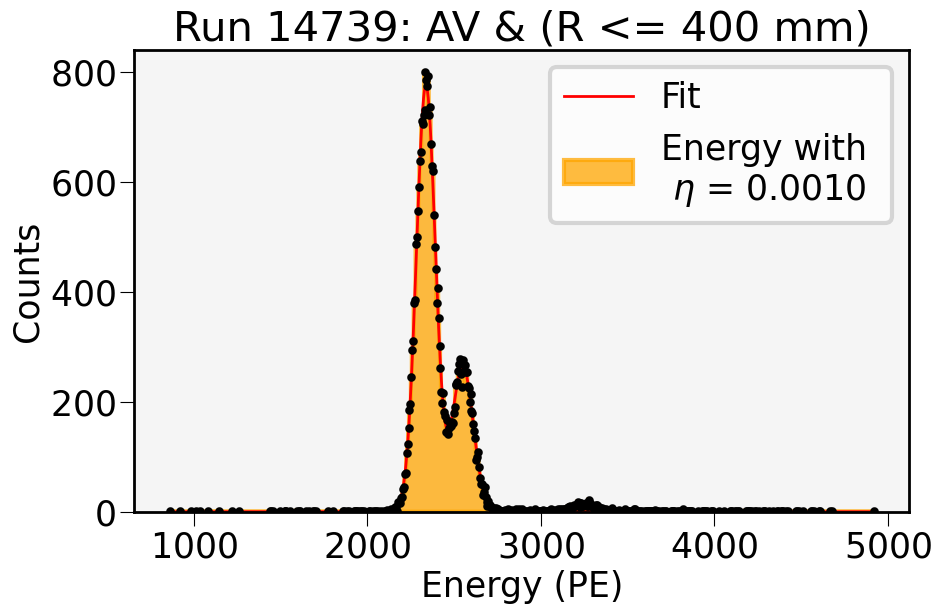

Run 14739 - Initial values: [2000, 2770.408163265306, 6.0315016138015345, 50, 3423.469387755102, 6.0315016138015345]
Run 14739 - Final values: [ 834.68003524 2752.6102614    56.94736601  284.85102993 3003.60731005
   61.09374402]
Run 14739 - Energy resolution: 4.8721%


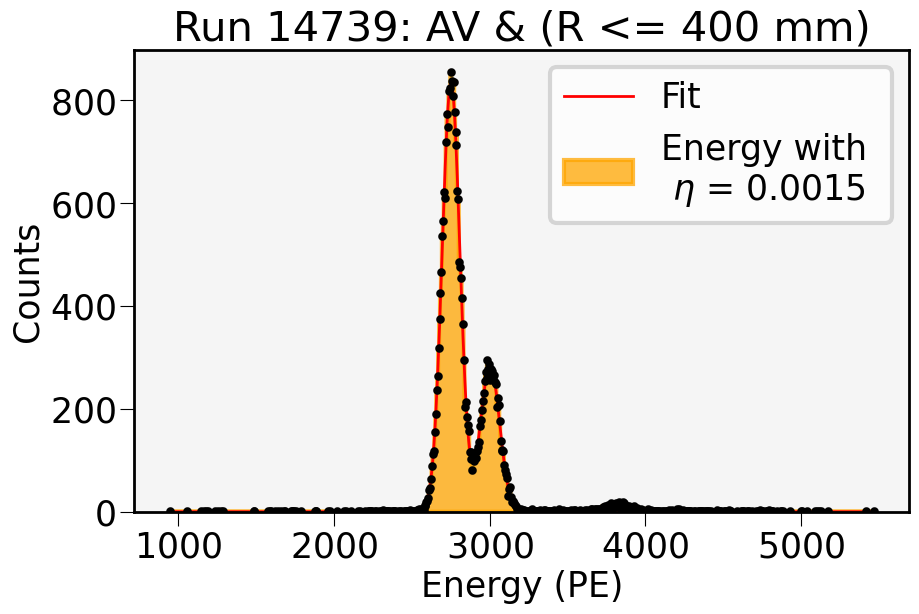

Run 14739 - Initial values: [2000, 3193.8775510204086, 7.255381069464955, 50, 3897.95918367347, 7.255381069464955]
Run 14739 - Final values: [ 950.68224363 3167.12442119   60.18157456  326.05373378 3456.64076043
   63.78095706]
Run 14739 - Energy resolution: 4.4750%


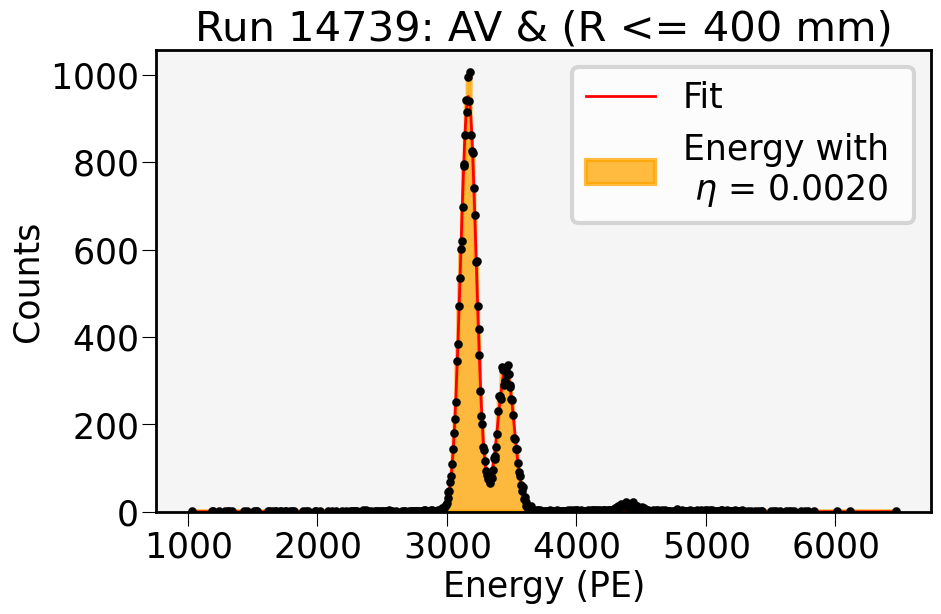

Run 14739 - Initial values: [2000, 3617.3469387755104, 8.551415280666806, 50, 4372.448979591837, 8.551415280666806]
Run 14739 - Final values: [1050.88232976 3581.56506642   64.09084411  360.03563701 3909.95162848
   67.64055031]
Run 14739 - Energy resolution: 4.2142%


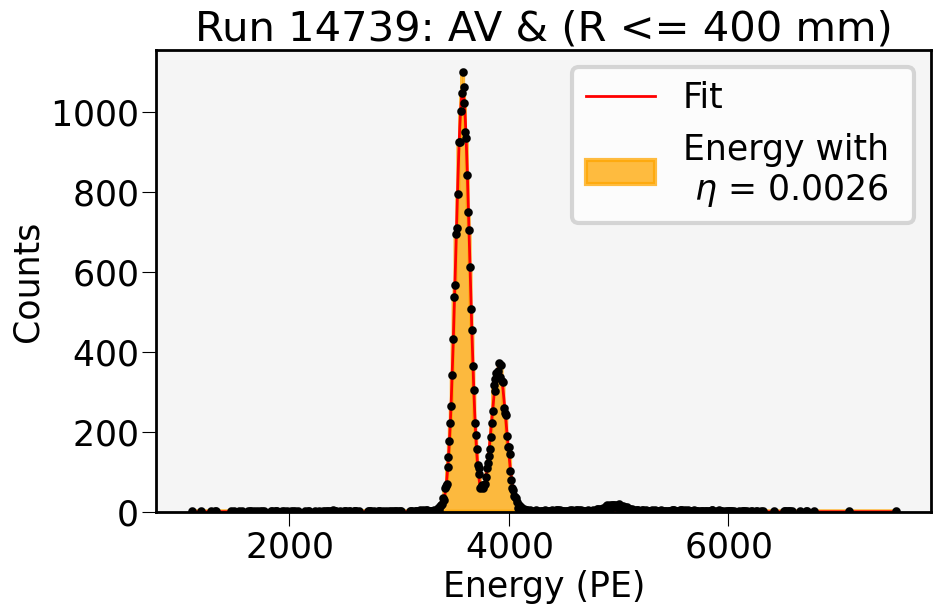

Run 14739 - Initial values: [2000, 4040.8163265306125, 9.847449491868657, 50, 4846.938775510204, 9.847449491868657]
Run 14739 - Final values: [1127.76938261 3996.0453877    68.53900282  386.01978274 4363.25655866
   72.32305665]
Run 14739 - Energy resolution: 4.0392%


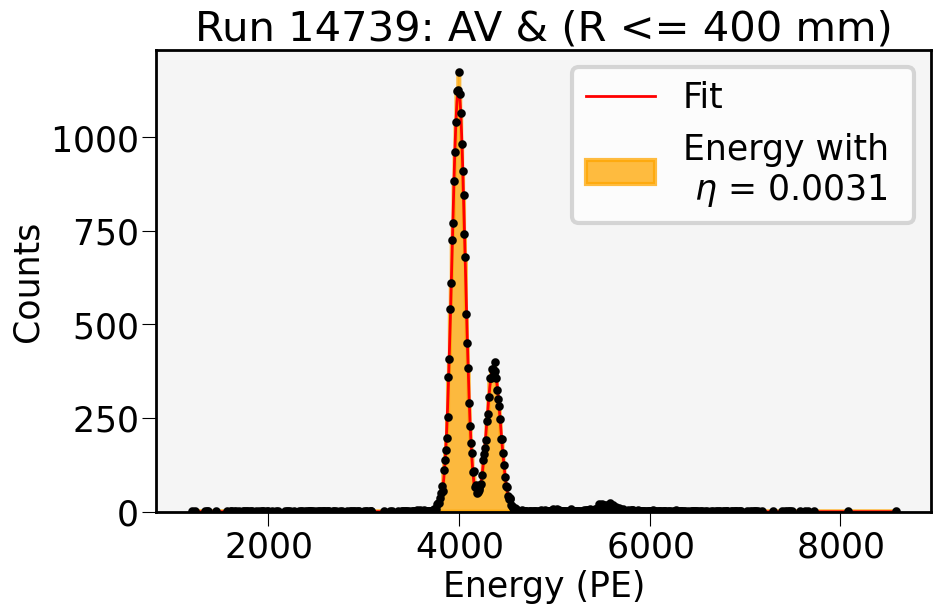

Run 14739 - Initial values: [2000, 4464.285714285715, 11.187397302826177, 50, 5321.428571428572, 11.187397302826177]
Run 14739 - Final values: [1190.27908635 4410.47490375   73.51621908  407.19627947 4816.55633507
   77.57651045]
Run 14739 - Energy resolution: 3.9254%


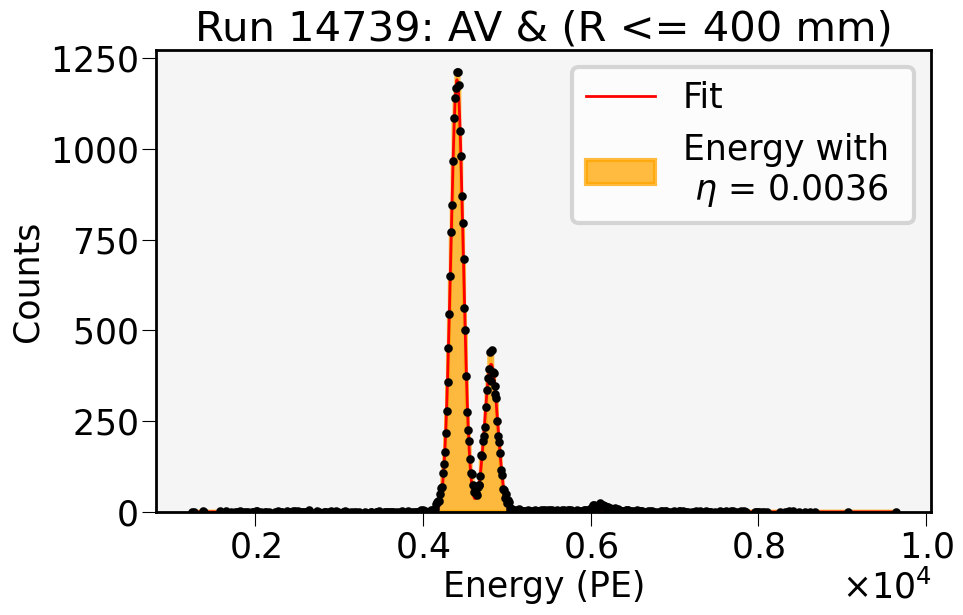

Run 14739 - Initial values: [2000, 4887.755102040817, 12.567523463089112, 50, 5795.91836734694, 12.567523463089112]
Run 14739 - Final values: [1243.90688486 4824.83788242   78.7148603   424.50147501 5269.88885727
  -83.33672631]
Run 14739 - Energy resolution: 3.8421%


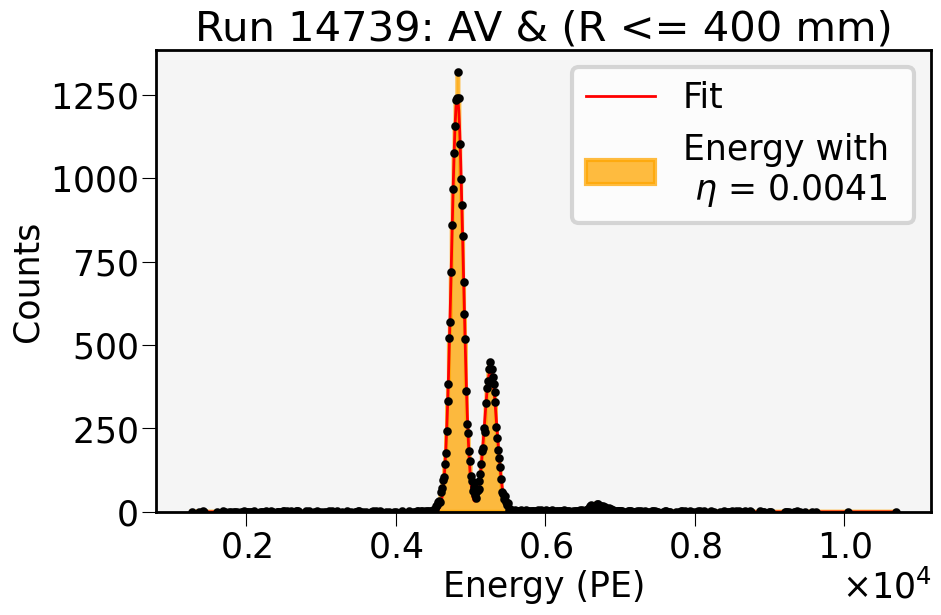

Run 14739 - Initial values: [2000, 5311.224489795919, 13.947649623352044, 50, 6270.408163265307, 13.947649623352044]
Run 14739 - Final values: [1283.90940495 5239.2408148    84.3880899   437.63365207 5722.95205994
  -89.45034893]
Run 14739 - Energy resolution: 3.7932%


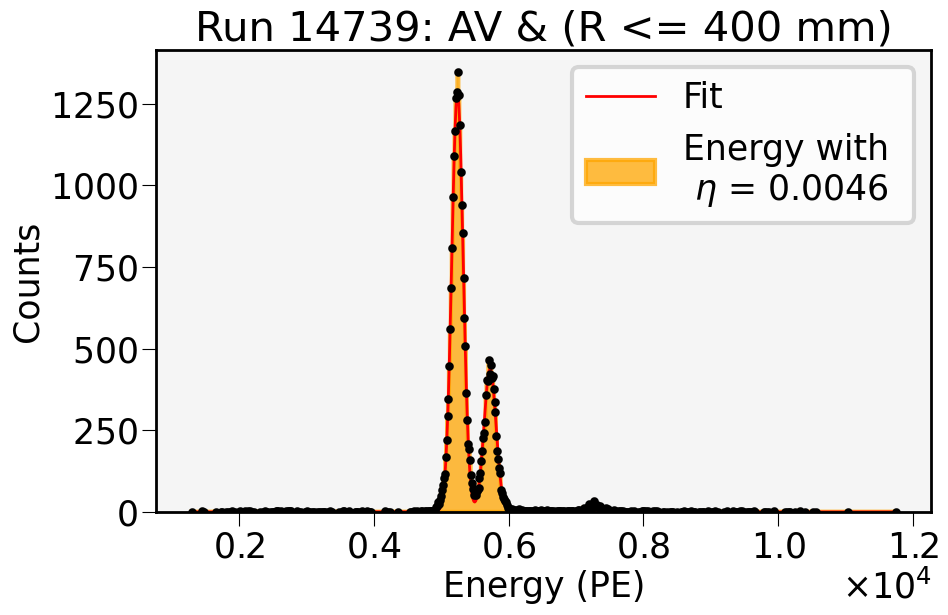

Run 14739 - Initial values: [2000, 5734.693877551021, 15.32777578361498, 50, 6744.897959183674, 15.32777578361498]
Run 14739 - Final values: [1313.92598808 5653.68744736   90.35862845  446.86143072 6175.95303909
   96.08971352]
Run 14739 - Energy resolution: 3.7638%


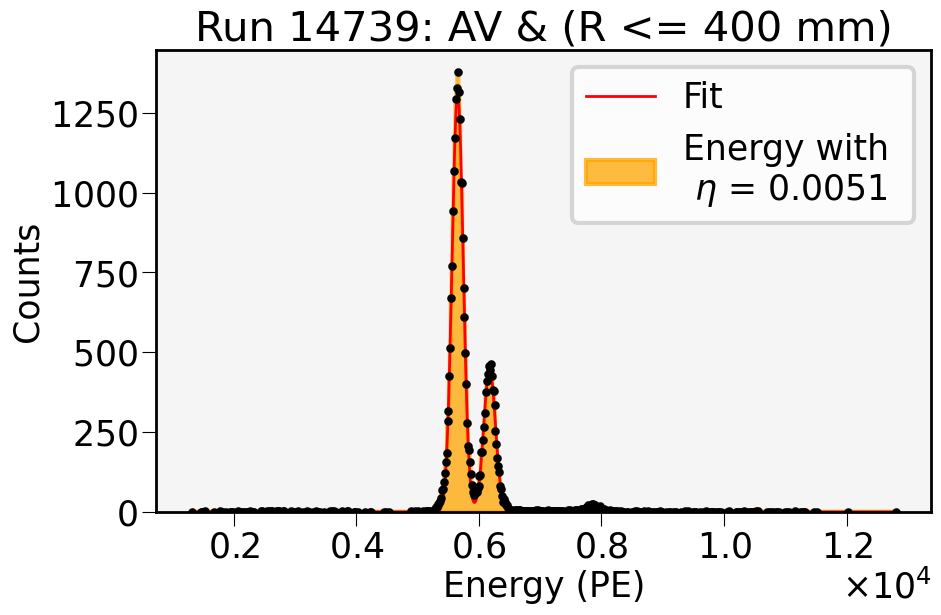

Run 14739 - Initial values: [2000, 6158.163265306123, 16.707901943877914, 50, 7219.387755102041, 16.707901943877914]
Run 14739 - Final values: [1336.80792989 6068.25791061   96.60132548  453.52540409 6629.12714636
  103.1016829 ]
Run 14739 - Energy resolution: 3.7490%


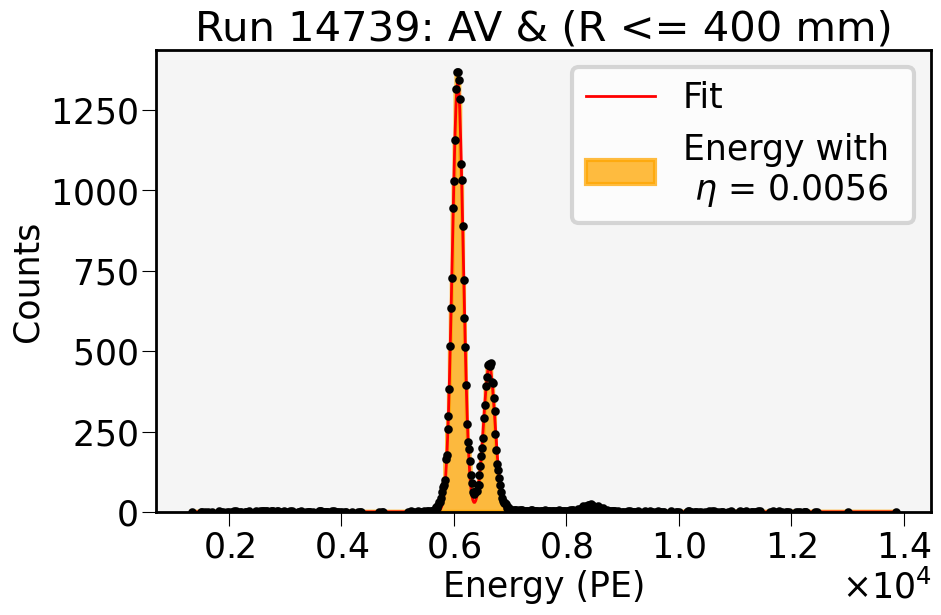

Run 14739 - Initial values: [2000, 6581.632653061225, 18.08802810414085, 50, 7693.877551020409, 18.08802810414085]
Run 14739 - Final values: [1354.89243631 6482.64261193  103.02876025  457.69549185 7081.98433496
  110.59131283]
Run 14739 - Energy resolution: 3.7428%


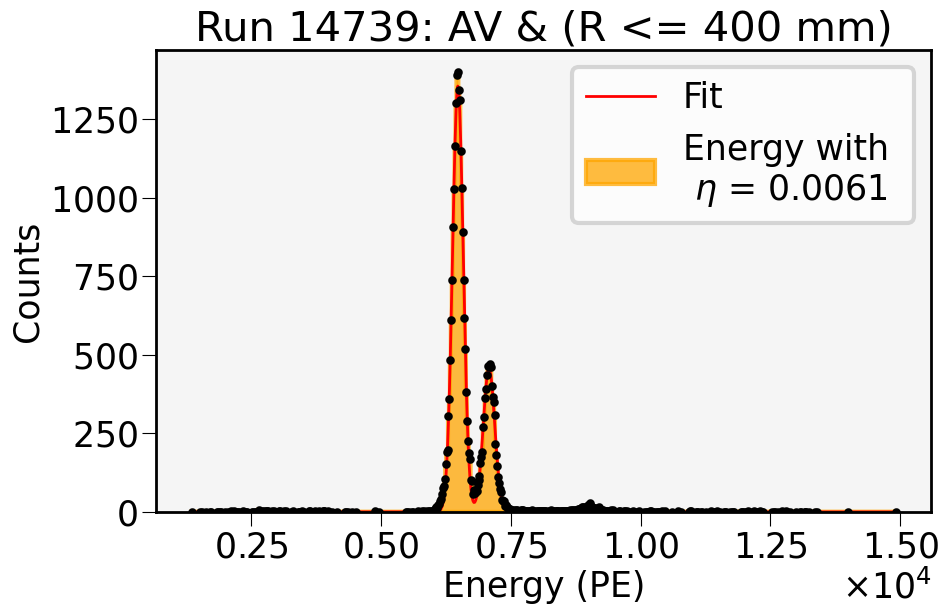

Run 14739 - Initial values: [2000, 7005.102040816327, 19.468154264403783, 50, 8168.367346938776, 19.468154264403783]
Run 14739 - Final values: [1366.285733   6896.95395664  109.86067445  461.13428704 7534.95641261
 -118.18453838]
Run 14739 - Energy resolution: 3.7512%


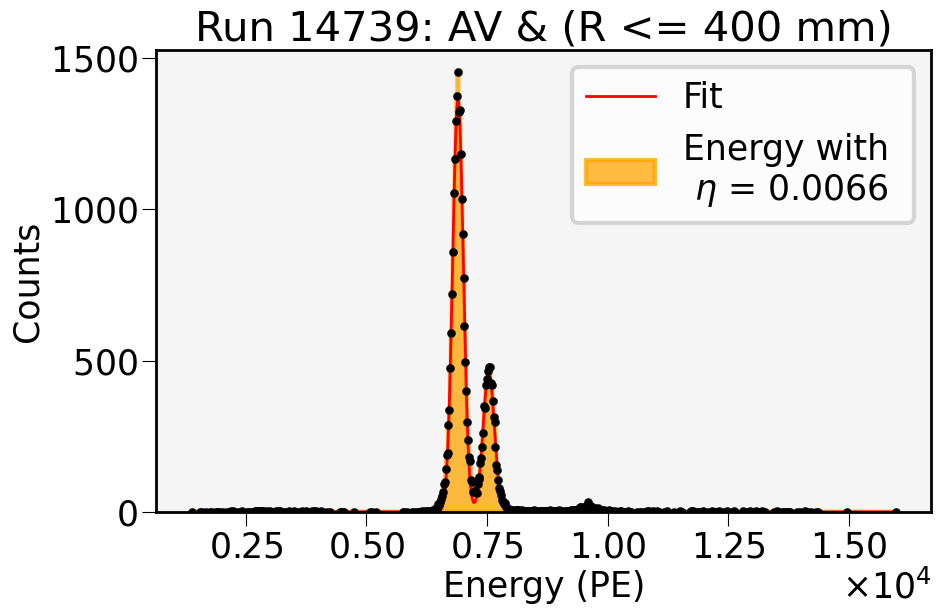

Run 14739 - Initial values: [2000, 7428.571428571429, 20.84828042466672, 50, 8642.857142857143, 20.84828042466672]
Run 14739 - Final values: [1375.16972707 7311.4039363   116.76939727  463.31328293 7987.8042219
 -126.08416998]
Run 14739 - Energy resolution: 3.7611%


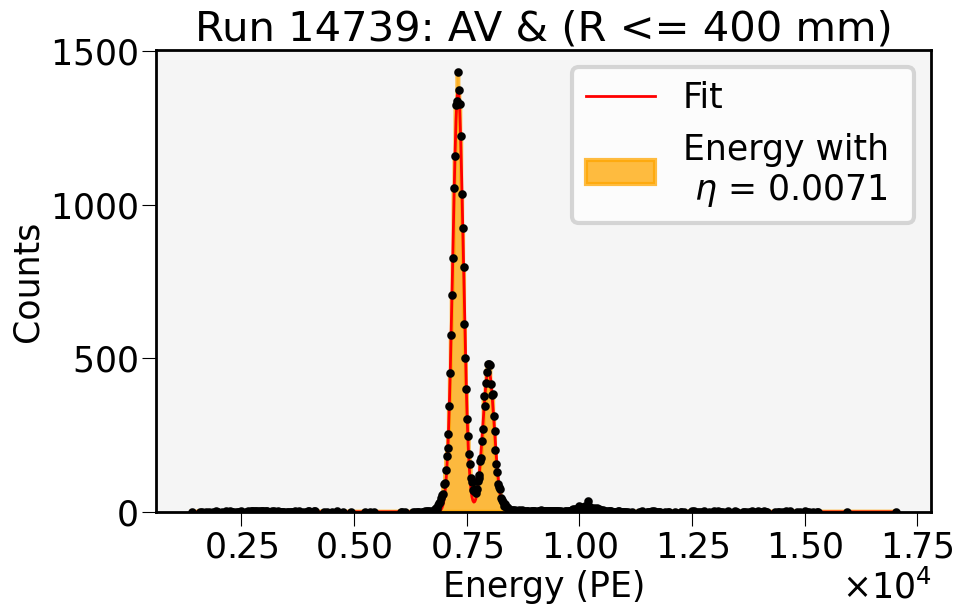

Run 14739 - Initial values: [2000, 7852.040816326531, 22.22840658492965, 50, 9117.34693877551, 22.22840658492965]
Run 14739 - Final values: [1381.95399603 7725.79448464  123.77649145  464.03025317 8440.79345874
  134.46677877]
Run 14739 - Energy resolution: 3.7730%


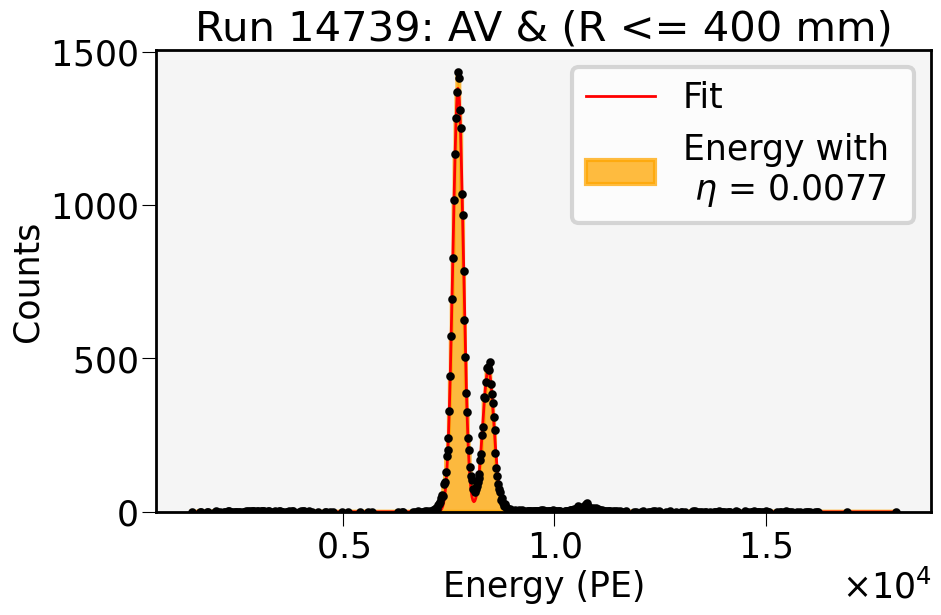

Run 14739 - Initial values: [2000, 8275.510204081635, 23.608532745192583, 50, 9591.83673469388, 23.608532745192583]
Run 14739 - Final values: [1387.36401188 8140.40207426  130.79493424  464.39084567 8893.73354649
  142.9471348 ]
Run 14739 - Energy resolution: 3.7839%


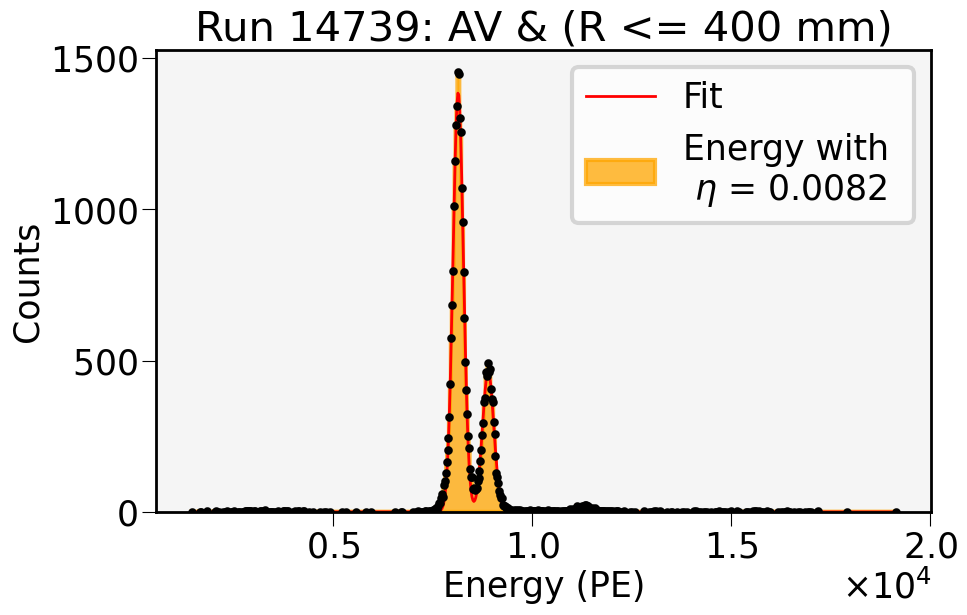

Run 14739 - Initial values: [2000, 8698.979591836734, 24.988658905455512, 50, 10066.326530612245, 24.988658905455512]
Run 14739 - Final values: [1390.76974625 8554.81122831  138.04207047  465.01845845 9346.48210517
  151.3679209 ]
Run 14739 - Energy resolution: 3.8001%


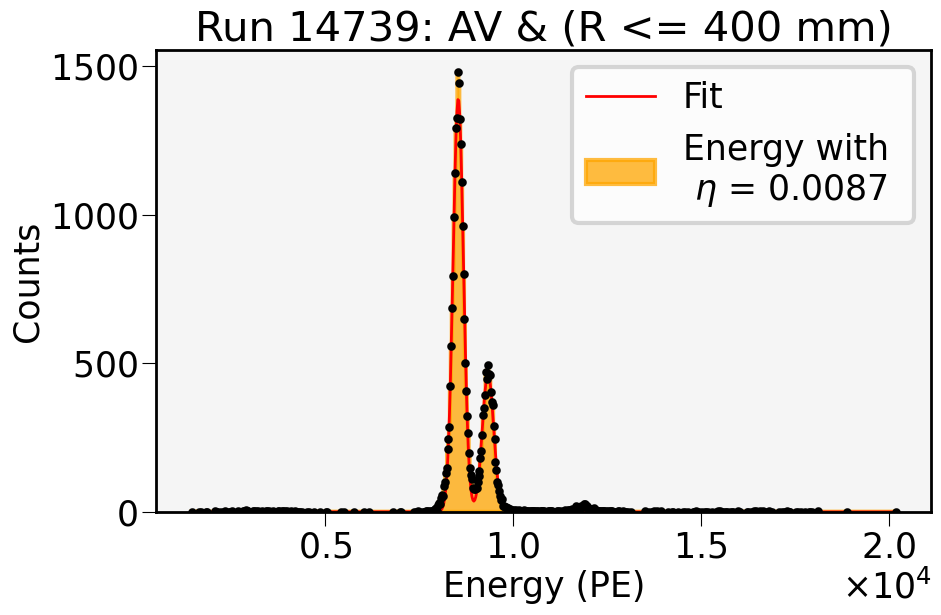

Run 14739 - Initial values: [2000, 9122.448979591838, 26.368785065718452, 50, 10540.816326530614, 26.368785065718452]
Run 14739 - Final values: [1392.4436556  8969.28411254  145.48664415  464.93554752 9798.87028644
  160.07752584]
Run 14739 - Energy resolution: 3.8199%


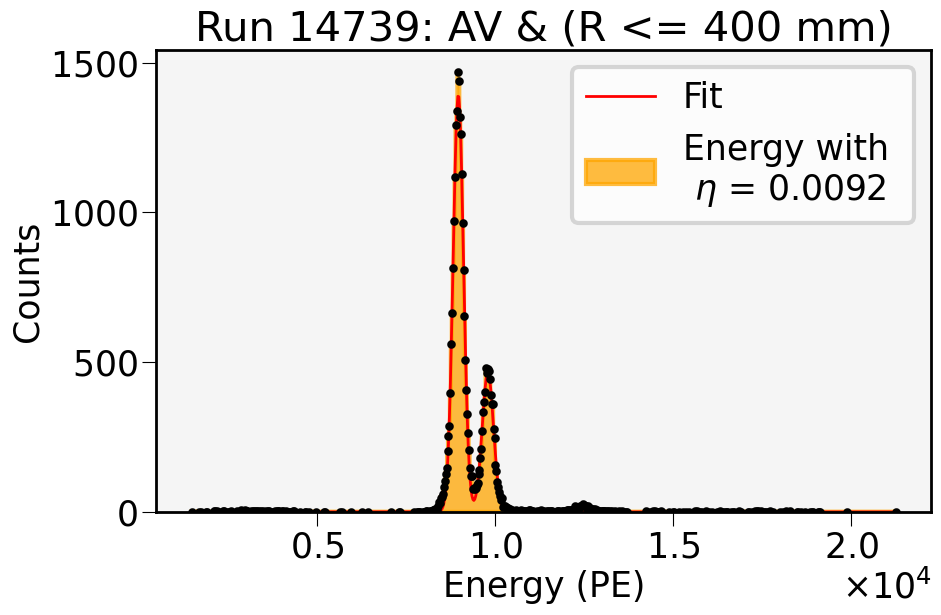

Run 14739 - Initial values: [2000, 9545.918367346942, 27.748911225981388, 50, 11015.306122448981, 27.748911225981388]
Run 14739 - Final values: [ 1394.31891007  9383.49282008   152.8305891    464.18821873
 10251.37948563   169.02054645]
Run 14739 - Energy resolution: 3.8356%


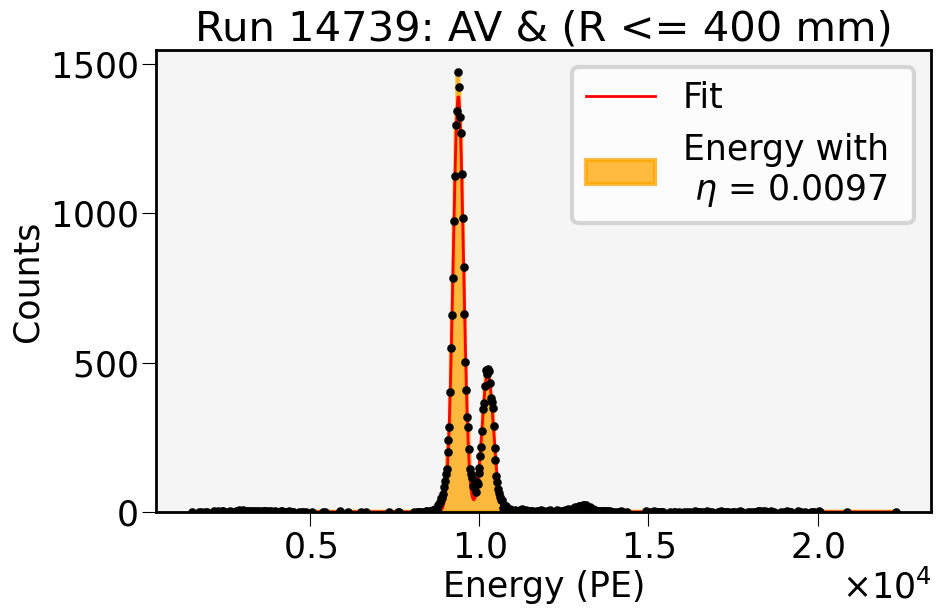

Run 14739 - Initial values: [2000, 9969.387755102041, 29.129037386244317, 50, 11489.795918367348, 29.129037386244317]
Run 14739 - Final values: [ 1393.67856813  9797.66395409   160.52922069   464.29174539
 10704.11600107   177.48327327]
Run 14739 - Energy resolution: 3.8585%


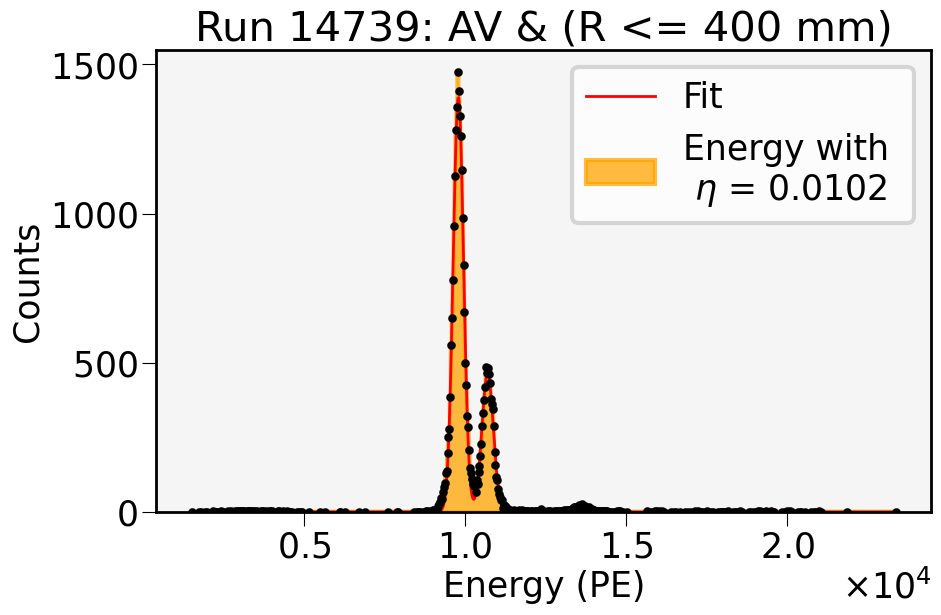

Run 14739 - Initial values: [2000, 10392.857142857143, 30.509163546507256, 50, 11964.285714285714, 30.509163546507256]
Run 14739 - Final values: [ 1392.80228697 10212.18778735   168.30632606   464.02720558
 11157.00059134   186.21822218]
Run 14739 - Energy resolution: 3.8813%


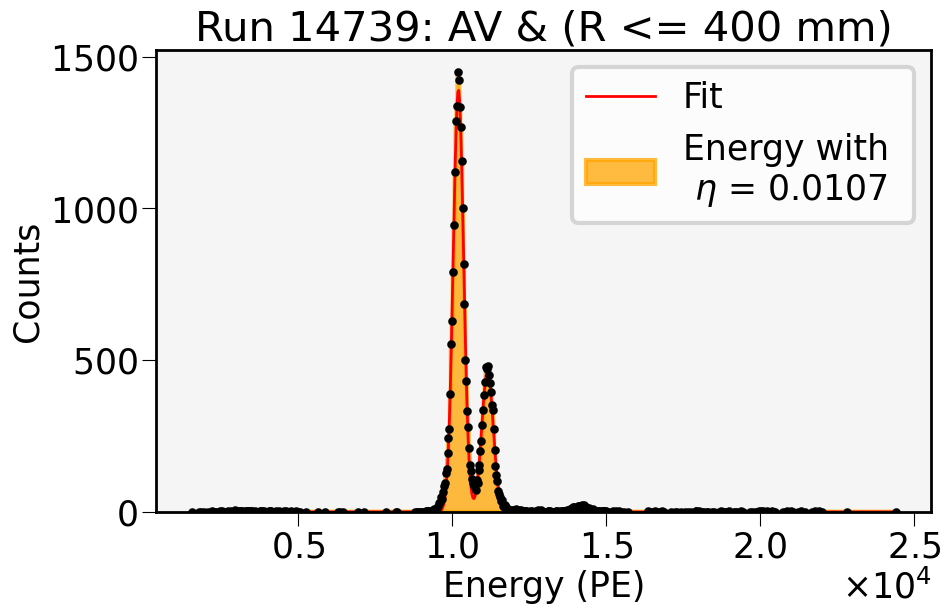

Run 14739 - Initial values: [2000, 10816.326530612247, 31.889289706770185, 50, 12438.775510204083, 31.889289706770185]
Run 14739 - Final values: [ 1393.12027966 10626.5528993    175.8687439    463.61457463
 11609.23642157   195.07897019]
Run 14739 - Energy resolution: 3.8975%


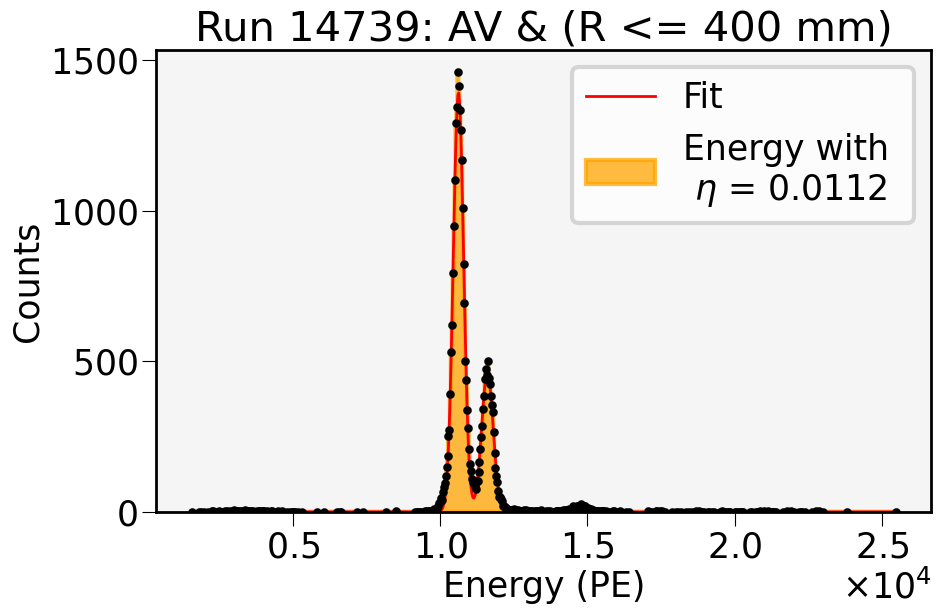

Run 14739 - Initial values: [2000, 11239.795918367348, 33.269415867033125, 50, 12913.26530612245, 33.269415867033125]
Run 14739 - Final values: [ 1391.39112313 11040.98721587   183.75107299   463.39115045
 12062.00590846   203.77562326]
Run 14739 - Energy resolution: 3.9193%


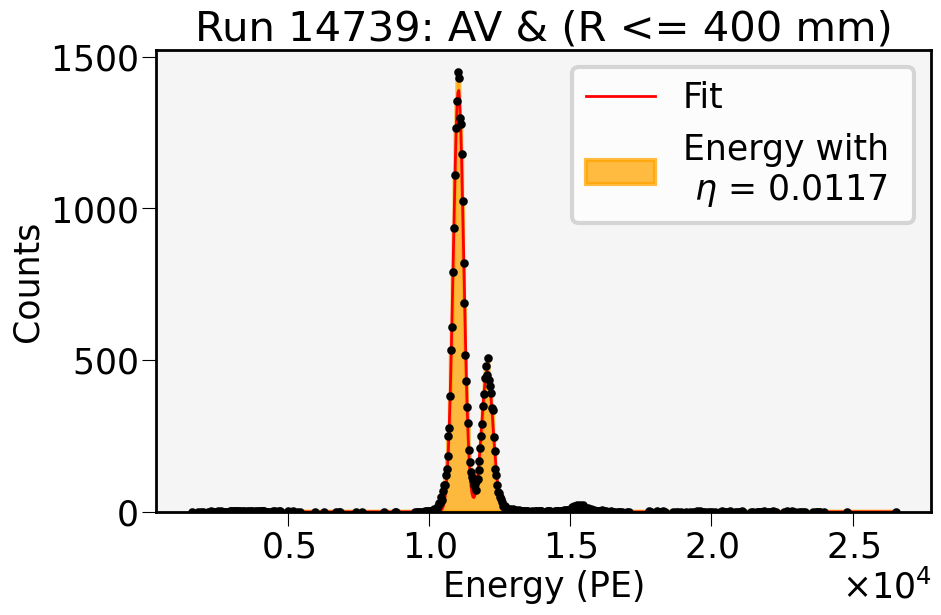

Run 14739 - Initial values: [2000, 11663.26530612245, 34.64954202729605, 50, 13387.755102040817, 34.64954202729605]
Run 14739 - Final values: [ 1390.40572146 11455.52414696   191.55877112   462.60849924
 12514.45601312   212.78316698]
Run 14739 - Energy resolution: 3.9380%


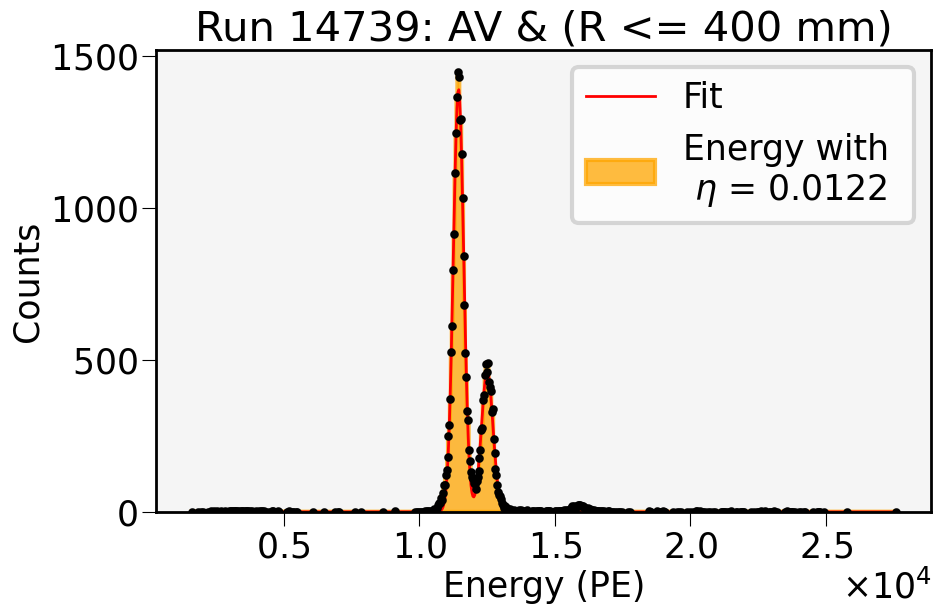

Run 14739 - Initial values: [2000, 12086.734693877552, 36.02966818755898, 50, 13862.244897959185, 36.02966818755898]
Run 14739 - Final values: [ 1389.55983968 11869.94208332   199.27574734   461.87057085
 12967.11916863   221.87332758]
Run 14739 - Energy resolution: 3.9536%


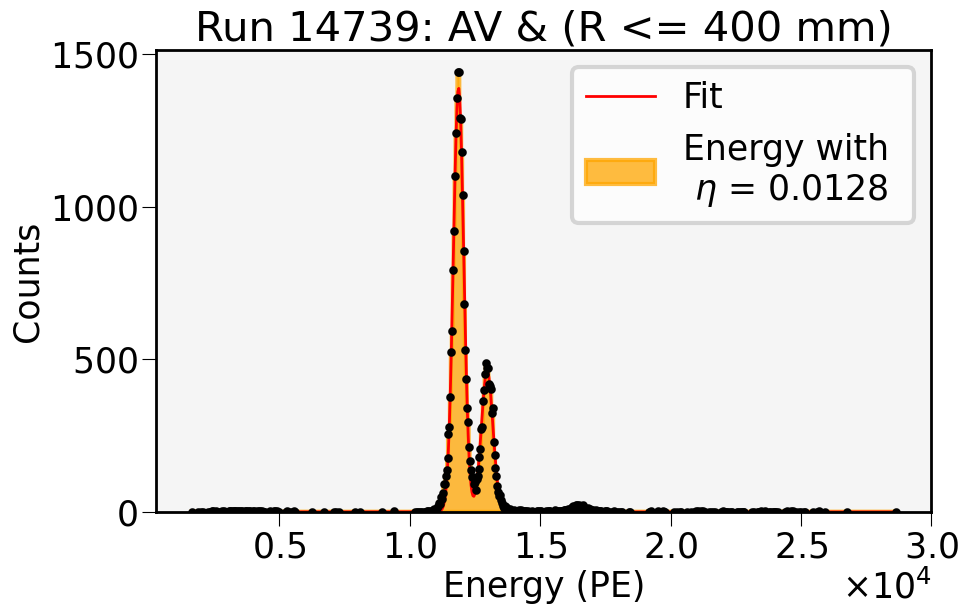

Run 14739 - Initial values: [2000, 12510.204081632653, 37.40979434782192, 50, 14336.734693877552, 37.40979434782192]
Run 14739 - Final values: [ 1387.14837788 12284.28917062   207.3334693    460.52986214
 13419.79843466   231.44792852]
Run 14739 - Energy resolution: 3.9748%


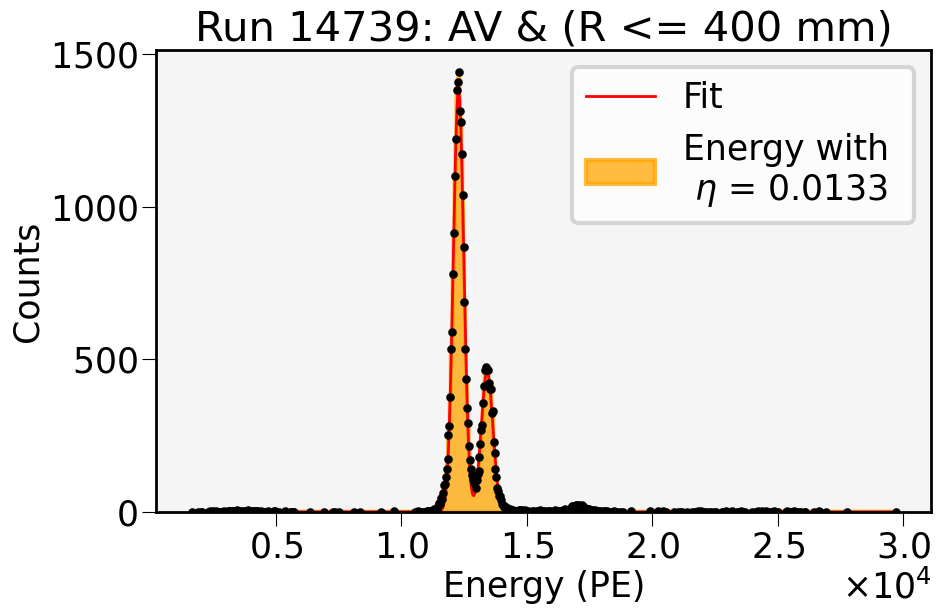

Run 14739 - Initial values: [2000, 12933.673469387757, 38.789920508084855, 50, 14811.22448979592, 38.789920508084855]
Run 14739 - Final values: [ 1385.83769936 12698.84731112   215.24171981   459.9982482
 13872.41019595  -240.30428911]
Run 14739 - Energy resolution: 3.9917%


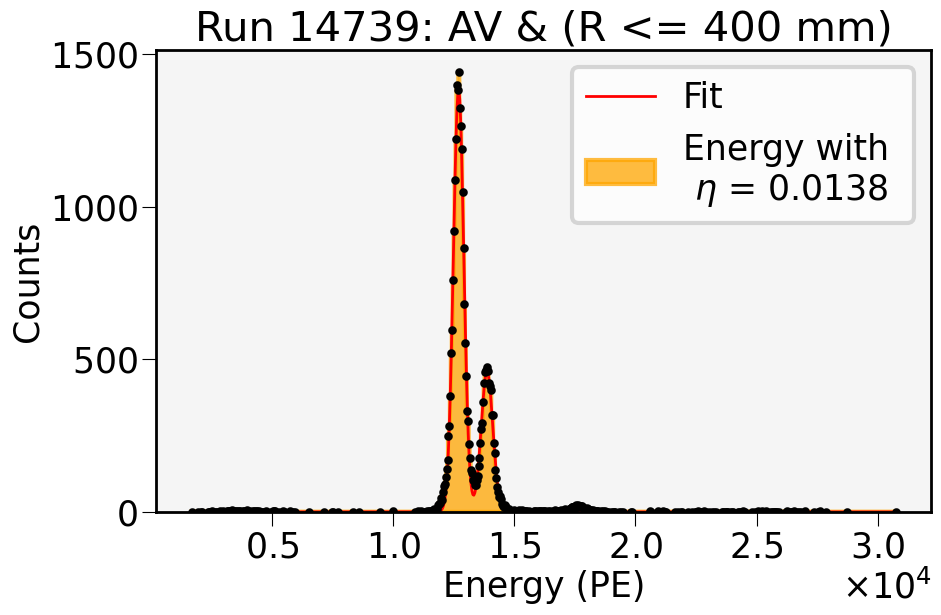

Run 14739 - Initial values: [2000, 13357.142857142859, 40.170046668347794, 50, 15285.714285714286, 40.170046668347794]
Run 14739 - Final values: [ 1383.88681196 13113.19242846   223.2777882    458.33264148
 14324.78279967   250.0326956 ]
Run 14739 - Energy resolution: 4.0098%


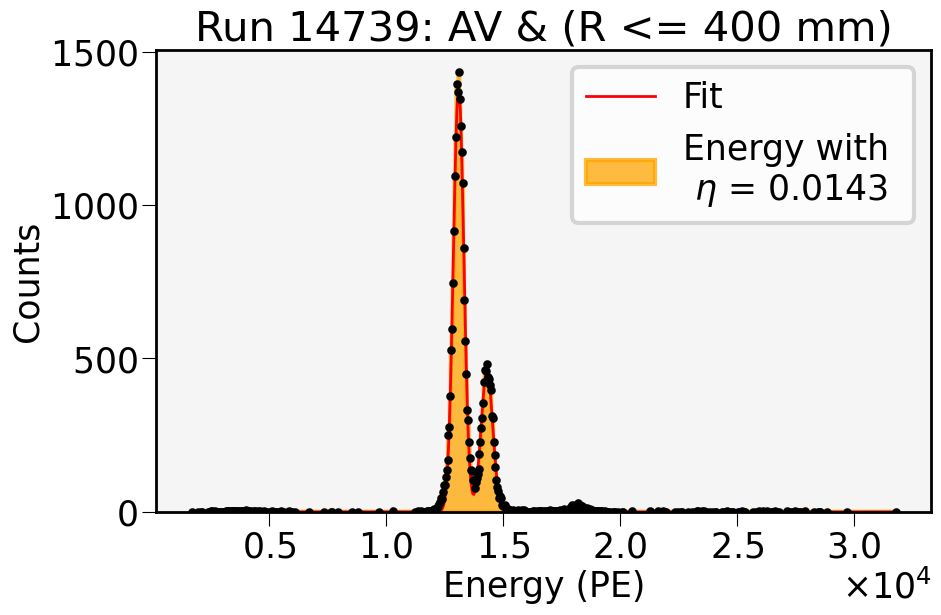

Run 14739 - Initial values: [2000, 13780.61224489796, 41.55017282861073, 50, 15760.204081632653, 41.55017282861073]
Run 14739 - Final values: [ 1382.32679946 13527.55073271   231.25426578   457.48202251
 14777.25899047   259.34680346]
Run 14739 - Energy resolution: 4.0259%


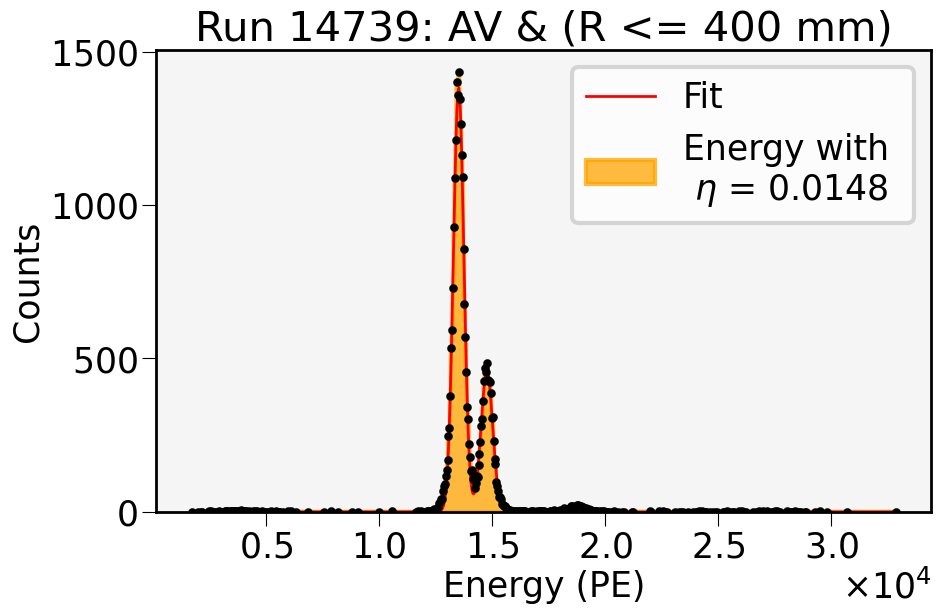

Run 14739 - Initial values: [2000, 14204.081632653062, 42.930298988873666, 50, 16234.693877551023, 42.930298988873666]
Run 14739 - Final values: [ 1381.10247139 13942.0306566    239.19339547   456.98739612
 15229.89647218   268.37483235]
Run 14739 - Energy resolution: 4.0403%


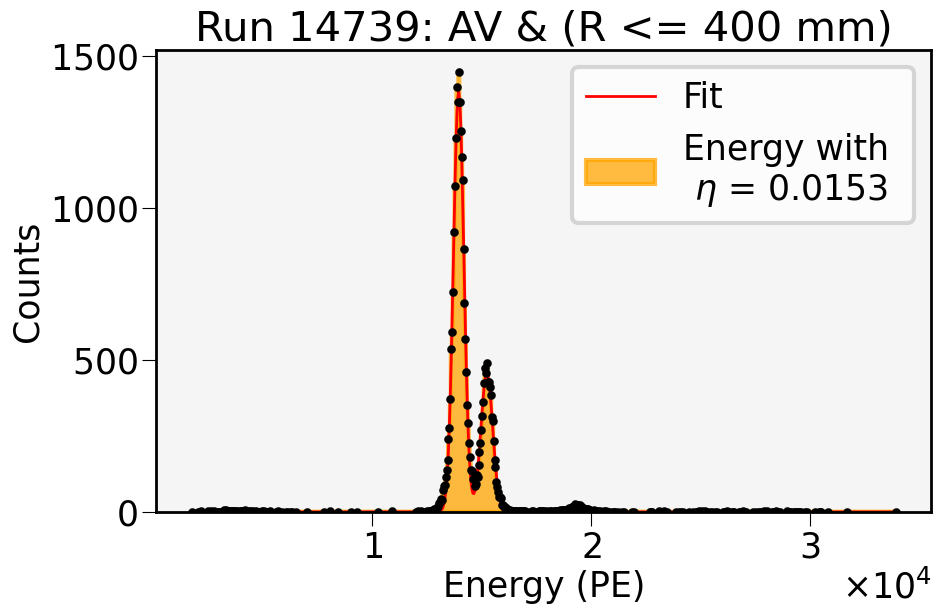

Run 14739 - Initial values: [2000, 14627.551020408166, 44.3104251491366, 50, 16709.18367346939, 44.3104251491366]
Run 14739 - Final values: [ 1381.07013064 14356.23817602   246.82435152   456.32332888
 15682.57945332  -277.78272634]
Run 14739 - Energy resolution: 4.0489%


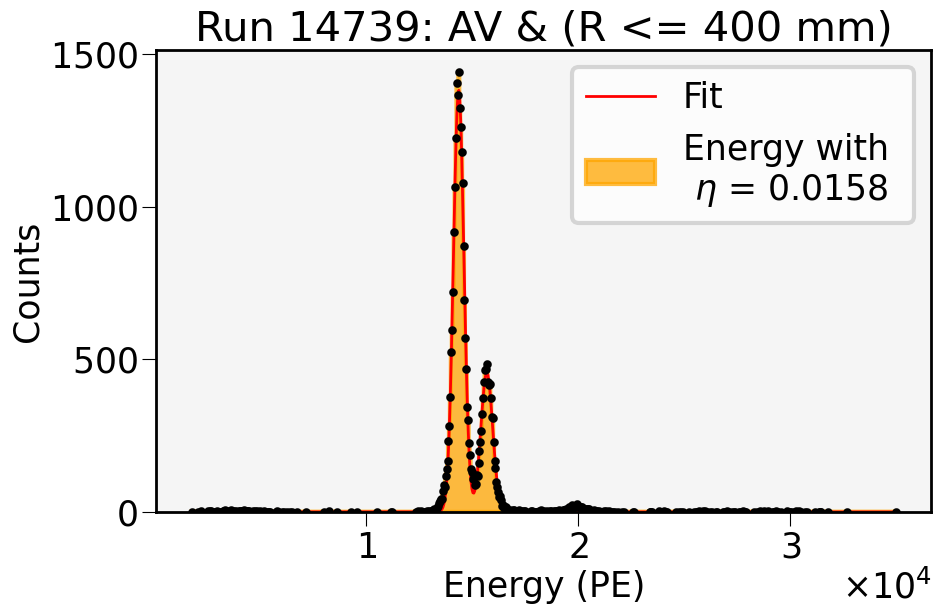

Run 14739 - Initial values: [2000, 15051.020408163267, 45.69055130939953, 50, 17183.67346938776, 45.69055130939953]
Run 14739 - Final values: [ 1379.03863358 14770.47657281   254.91375156   455.16706059
 16135.47704155   287.58690299]
Run 14739 - Energy resolution: 4.0643%


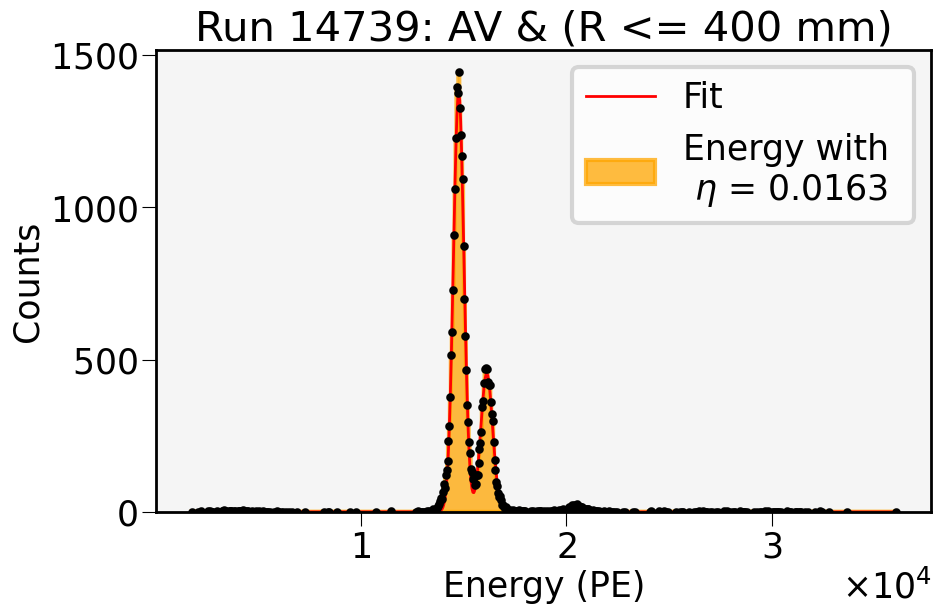

Run 14739 - Initial values: [2000, 15474.489795918367, 47.07067746966247, 50, 17658.163265306124, 47.07067746966247]
Run 14739 - Final values: [ 1377.49962194 15185.19008829   262.99683976   455.0820319
 16588.16787294   296.41491916]
Run 14739 - Energy resolution: 4.0787%


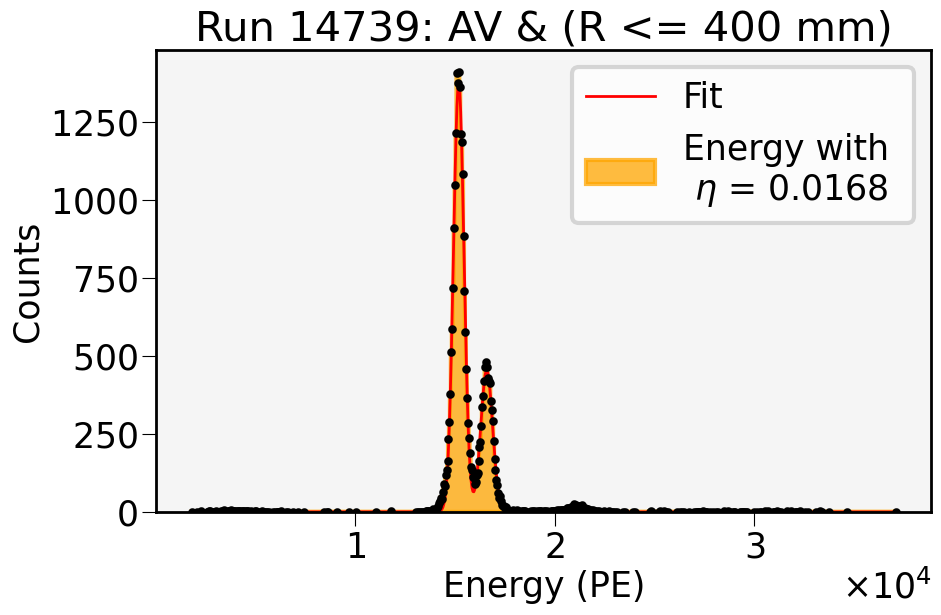

Run 14739 - Initial values: [2000, 15897.959183673469, 48.450803629925396, 50, 18132.65306122449, 48.450803629925396]
Run 14739 - Final values: [ 1375.6681414  15599.69346066   271.10519355   454.28089343
 17041.09735209   305.93741783]
Run 14739 - Energy resolution: 4.0927%


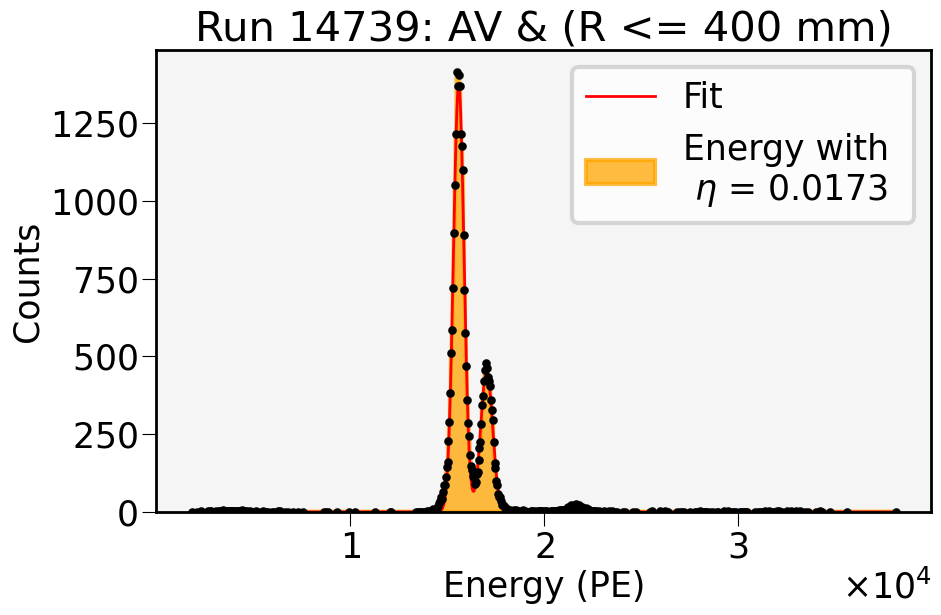

Run 14739 - Initial values: [2000, 16321.428571428574, 49.83092979018834, 50, 18607.14285714286, 49.83092979018834]
Run 14739 - Final values: [1.36838294e+03 1.60152450e+04 2.81946223e+02 1.79954605e+01
 2.22175880e+04 4.59529463e+02]
Run 14739 - Energy resolution: 4.1459%


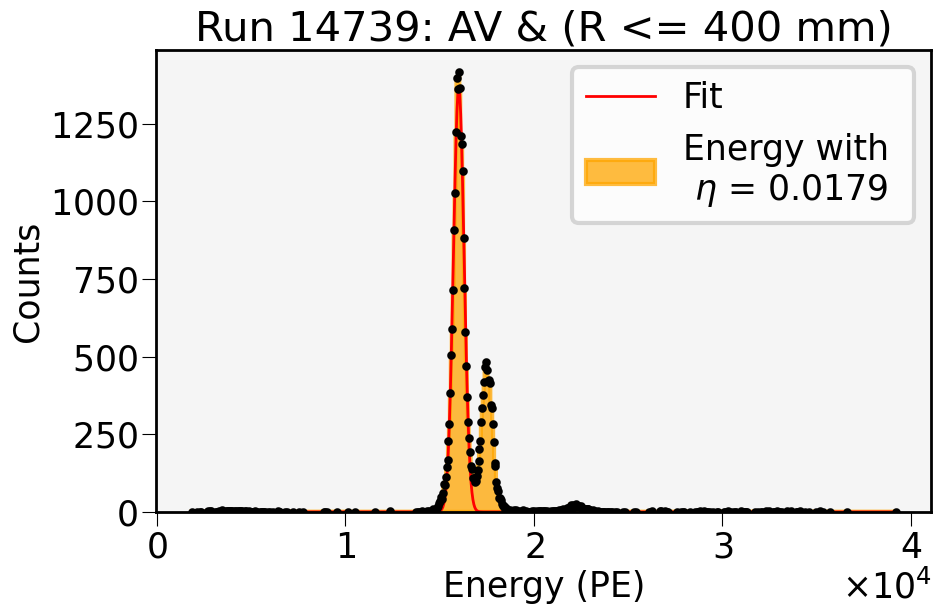

Run 14739 - Initial values: [2000, 16744.897959183676, 51.211055950451275, 50, 19081.632653061228, 51.211055950451275]
Run 14739 - Final values: [ 1373.06746443 16428.73140015   287.20871813   454.04011391
 17946.33747333   323.53006697]
Run 14739 - Energy resolution: 4.1170%


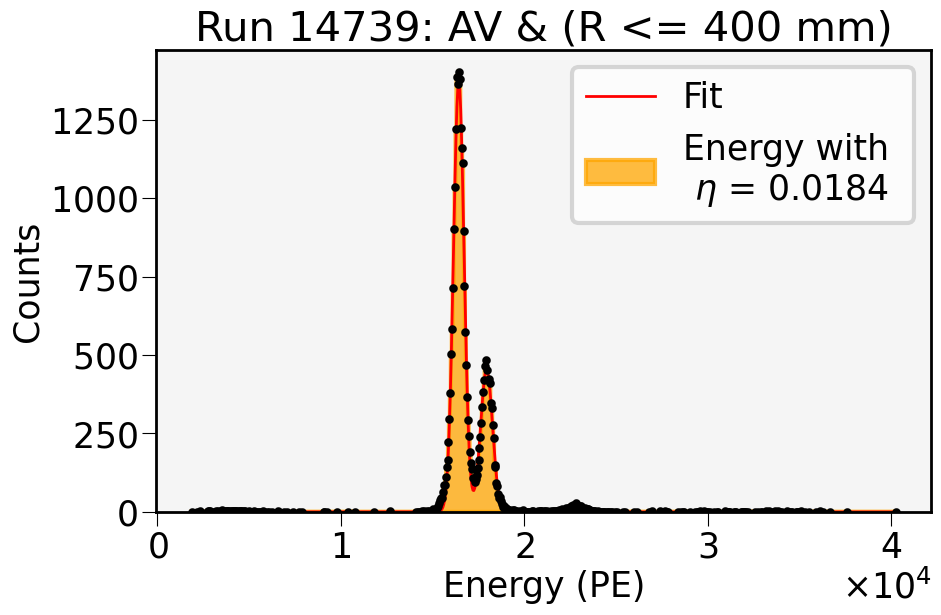

Run 14739 - Initial values: [2000, 17168.367346938776, 52.5911821107142, 50, 19556.122448979593, 52.5911821107142]
Run 14739 - Final values: [ 1371.91040455 16843.10805033   295.23864306   453.31049948
 18399.09736815  -333.0187551 ]
Run 14739 - Energy resolution: 4.1280%


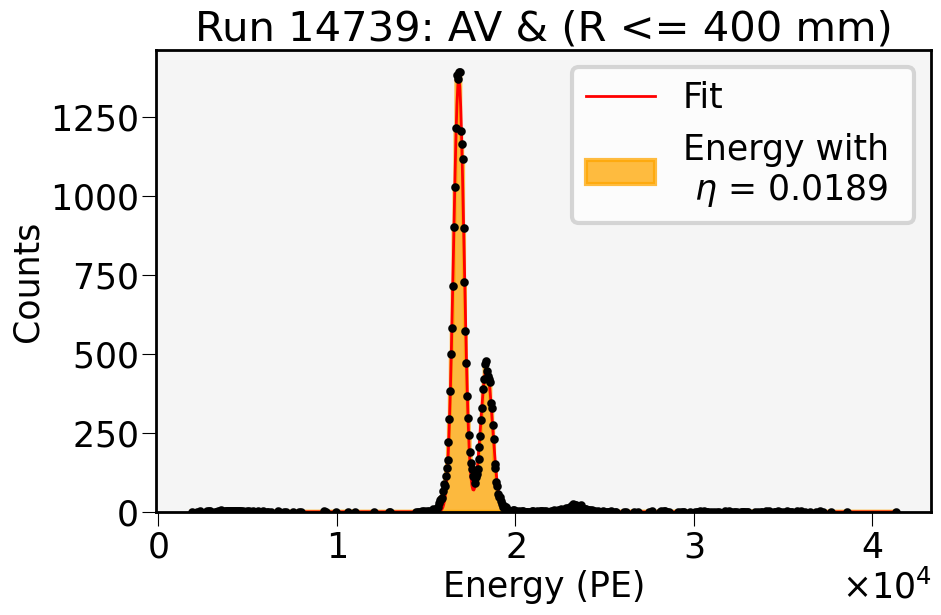

Run 14739 - Initial values: [2000, 17591.836734693883, 53.97130827097715, 50, 20030.612244897962, 53.97130827097715]
Run 14739 - Final values: [ 1371.43067349 17257.63605457   303.0557031    453.010258
 18851.99455307   341.97271278]
Run 14739 - Energy resolution: 4.1355%


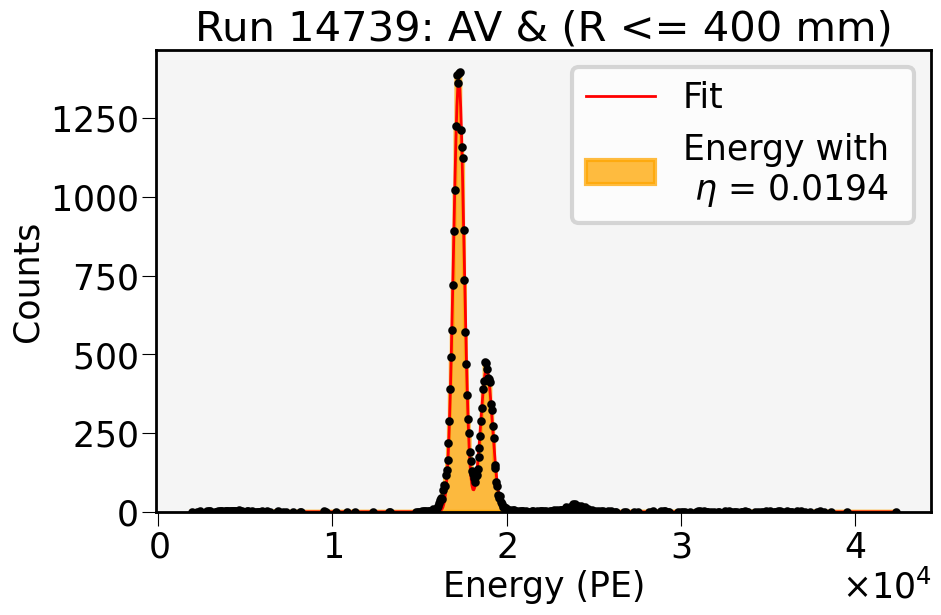

Run 14739 - Initial values: [2000, 18015.306122448983, 55.35143443124008, 50, 20505.102040816328, 55.35143443124008]
Run 14739 - Final values: [ 1370.08518902 17672.09273021   311.19113157   452.56363628
 19304.15012056   351.11919072]
Run 14739 - Energy resolution: 4.1470%


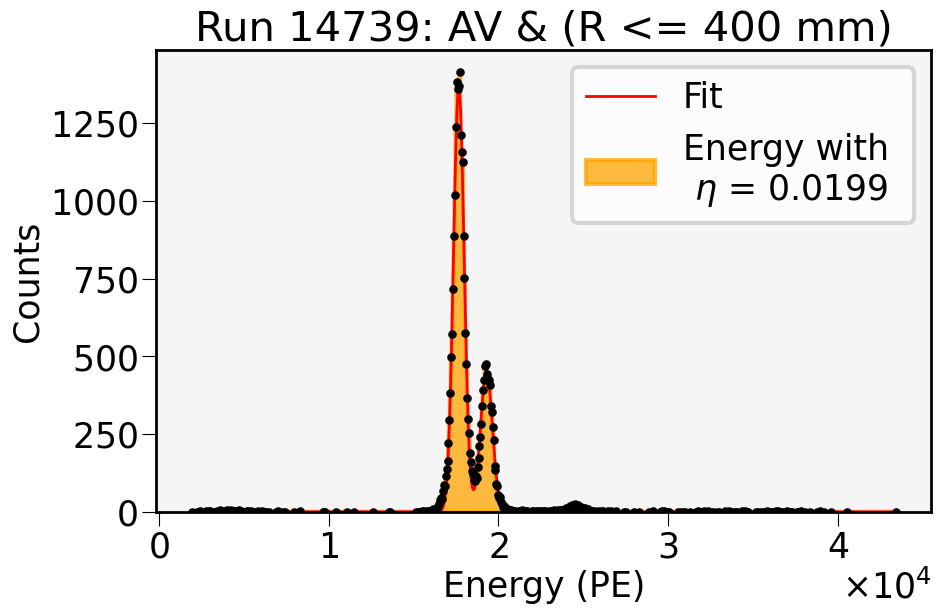

Run 14739 - Initial values: [2000, 18438.775510204083, 56.731560591503005, 50, 20979.591836734697, 56.731560591503005]
Run 14739 - Final values: [ 1369.38883007 18086.30822319   319.09861893   452.26107639
 19756.36134382   360.21082211]
Run 14739 - Energy resolution: 4.1550%


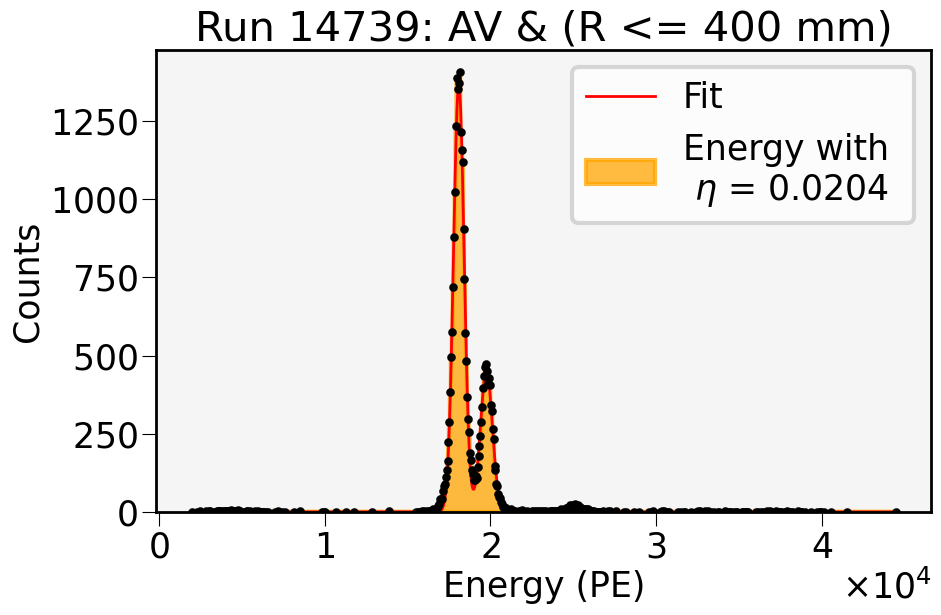

Run 14739 - Initial values: [2000, 18862.244897959183, 58.11168675176594, 50, 21454.081632653062, 58.11168675176594]
Run 14739 - Final values: [ 1368.06005169 18500.73905744   327.25395117   451.99219732
 20208.78971767   369.21663457]
Run 14739 - Energy resolution: 4.1657%


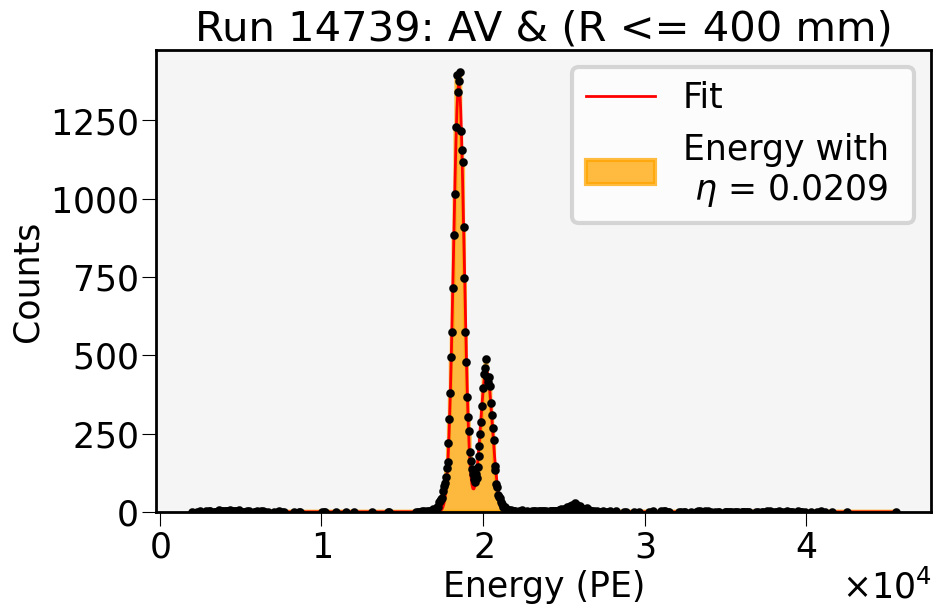

Run 14739 - Initial values: [2000, 19285.714285714286, 59.49181291202888, 50, 21928.571428571428, 59.49181291202888]
Run 14739 - Final values: [ 1366.76360507 18915.06012133   335.41752603   451.65060307
 20661.44888171   378.27878913]
Run 14739 - Energy resolution: 4.1761%


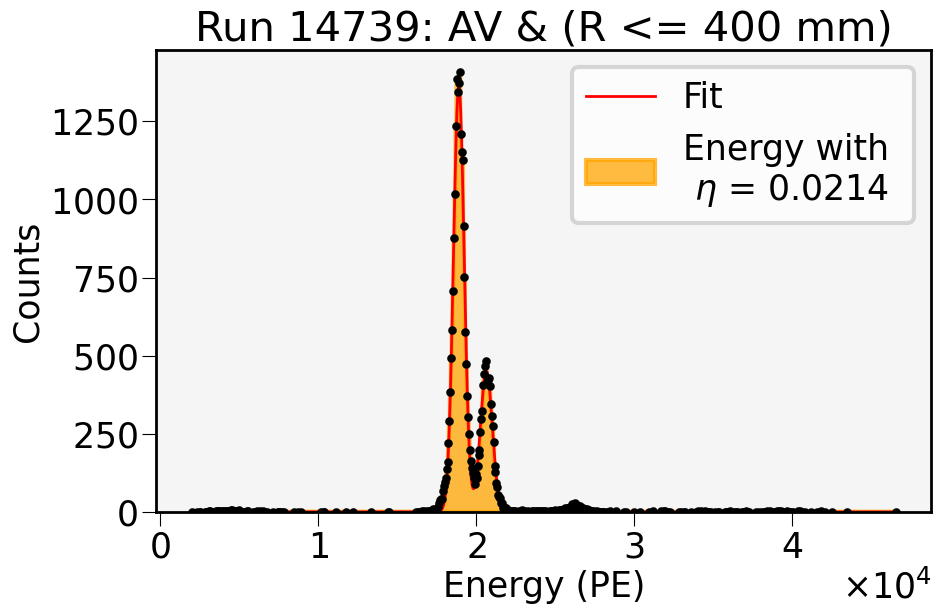

Run 14739 - Initial values: [2000, 19709.18367346939, 60.871939072291816, 50, 22403.0612244898, 60.871939072291816]
Run 14739 - Final values: [ 1365.12207526 19329.66601658   343.73329018   451.70098579
 21113.94423911   386.82702892]
Run 14739 - Energy resolution: 4.1878%


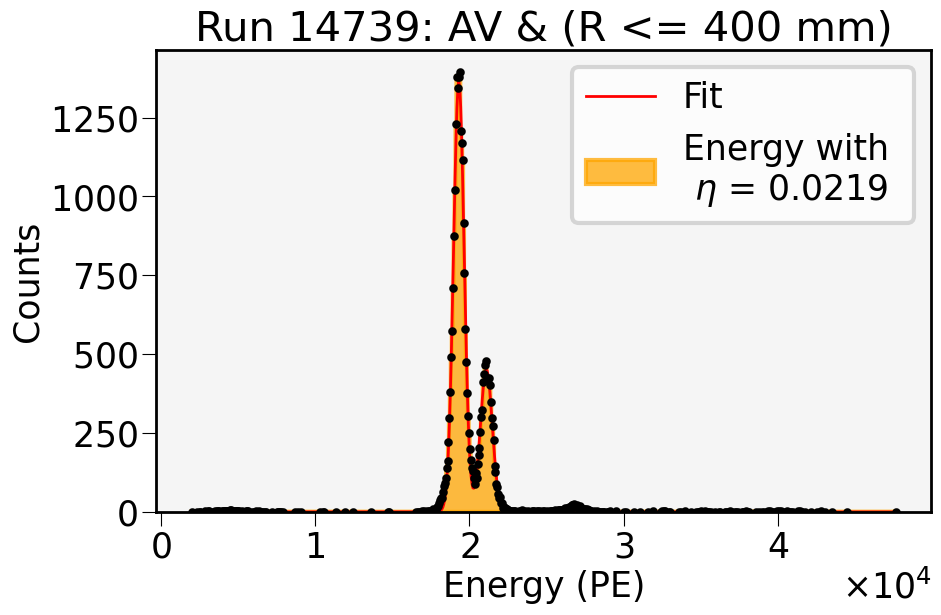

Run 14739 - Initial values: [2000, 20132.653061224493, 62.25206523255474, 50, 22877.551020408166, 62.25206523255474]
Run 14739 - Final values: [ 1364.2085414  19744.14298634   351.8013944    450.9111423
 21566.93724617   396.35313964]
Run 14739 - Energy resolution: 4.1961%


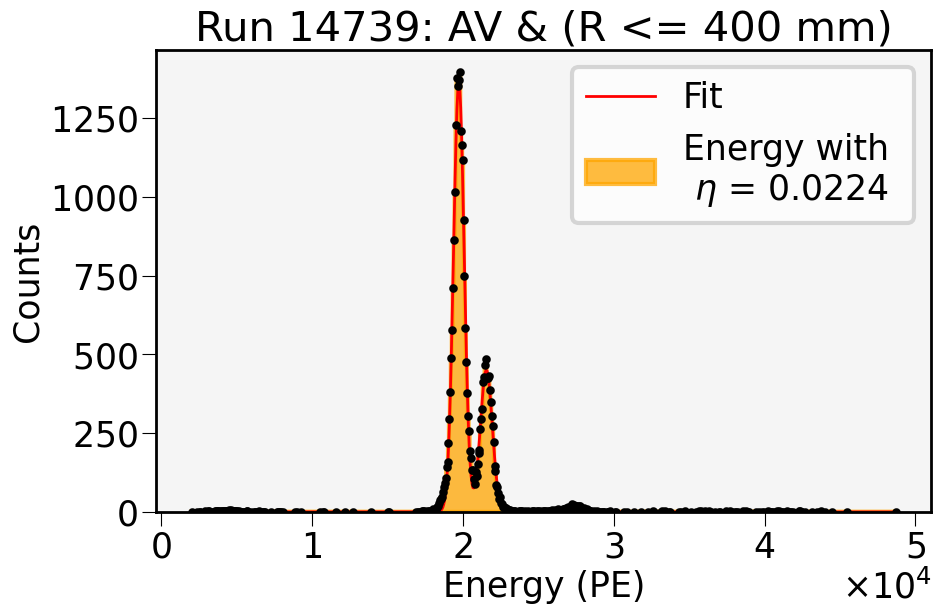

Run 14739 - Initial values: [2000, 20556.122448979593, 63.63219139281767, 50, 23352.04081632653, 63.63219139281767]
Run 14739 - Final values: [ 1363.71051149 20158.42377329   359.74498428   450.22348566
 22019.47093945   405.86800527]
Run 14739 - Energy resolution: 4.2027%


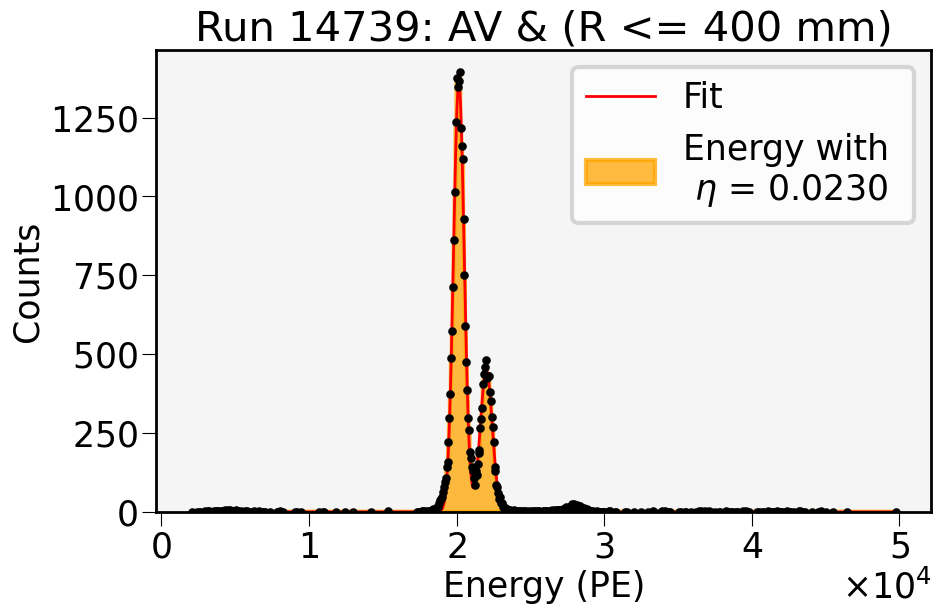

Run 14739 - Initial values: [2000, 20979.591836734697, 65.01231755308062, 50, 23826.5306122449, 65.01231755308062]
Run 14739 - Final values: [ 1363.0572101  20572.75956111   367.70134066   449.41208408
 22471.64386896   415.66408197]
Run 14739 - Energy resolution: 4.2091%


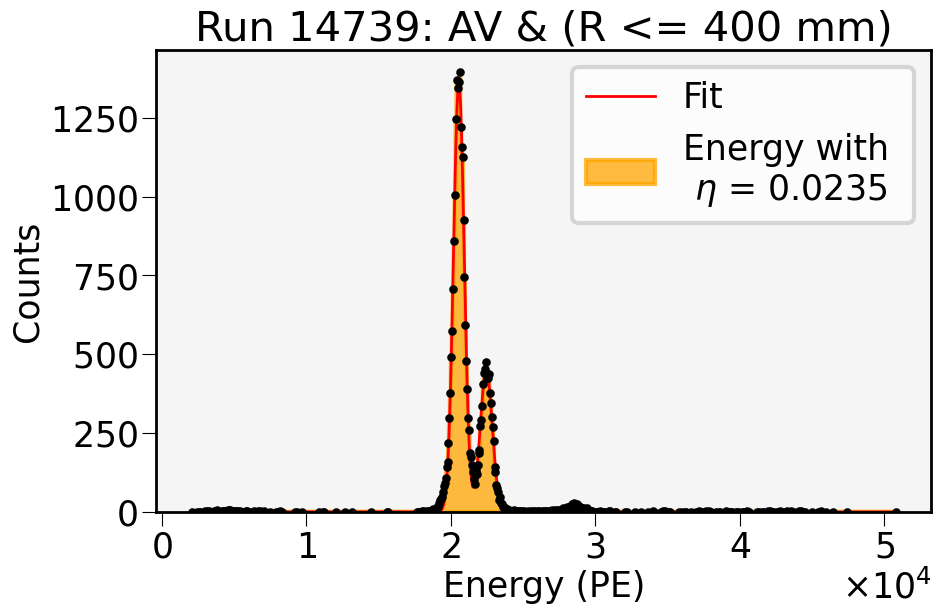

Run 14739 - Initial values: [2000, 21403.0612244898, 66.39244371334355, 50, 24301.02040816327, 66.39244371334355]
Run 14739 - Final values: [ 1361.77579912 20987.11360766   375.95788229   449.1820032
 22923.84863947   424.70435566]
Run 14739 - Energy resolution: 4.2187%


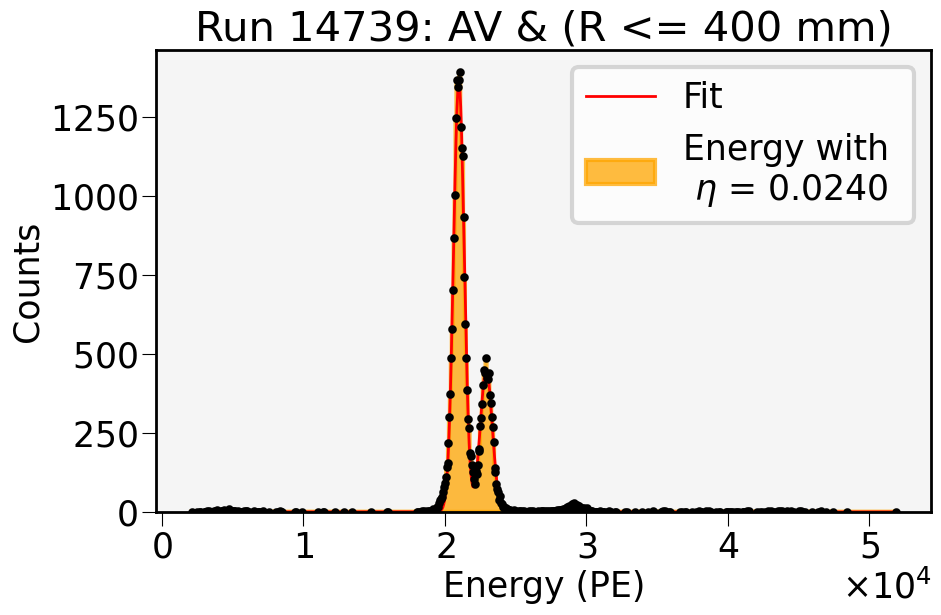

Run 14739 - Initial values: [2000, 21826.5306122449, 67.77256987360647, 50, 24775.510204081635, 67.77256987360647]
Run 14739 - Final values: [ 1360.82988772 21401.64053211   384.11849165   449.27823529
 23376.4077081    433.21490866]
Run 14739 - Energy resolution: 4.2268%


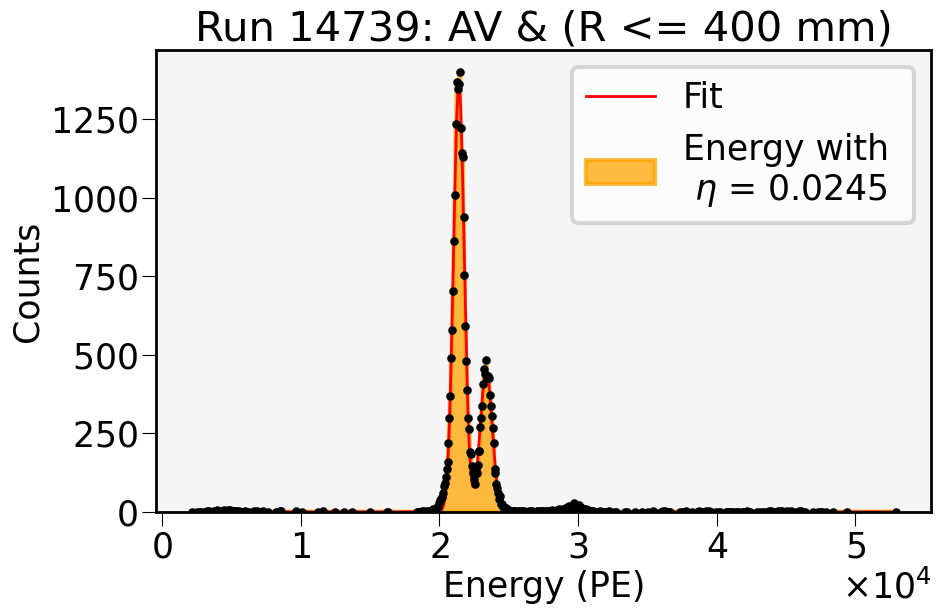

Run 14739 - Initial values: [2000, 22250.0, 69.1526960338694, 50, 25250.0, 69.1526960338694]
Run 14739 - Final values: [ 1360.11575415 21815.9322336    392.17311748   448.4865538
 23828.60238341   443.01694394]
Run 14739 - Energy resolution: 4.2335%


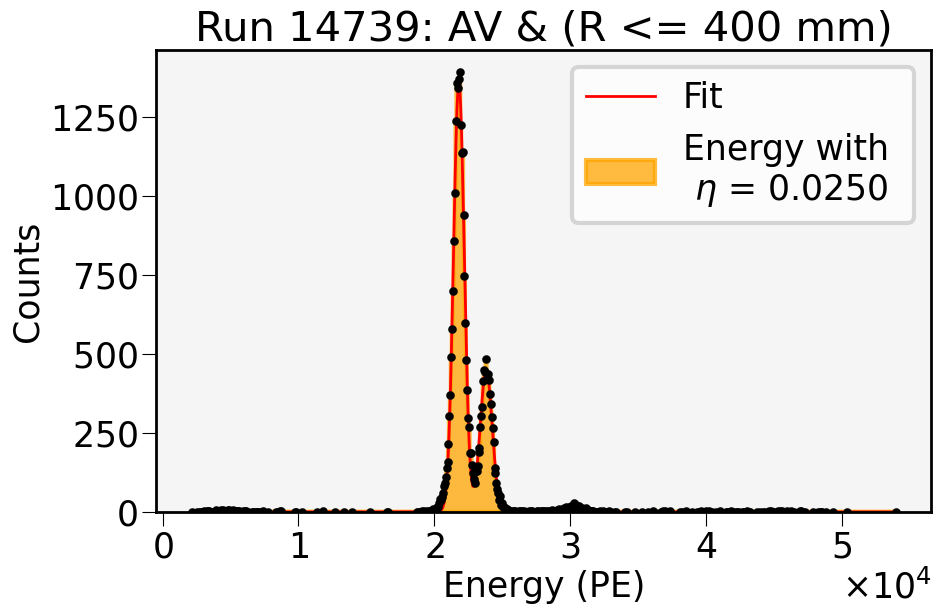

In [39]:
# Global
run_id = 14739                          # Reference run for energy map corrections
n_bins = 750
rad_lim = 400

E_resolution = []                       # Store the energy resolution values
eta_values = np.linspace(0, 0.025, 50)  # η variation

for eta in eta_values:

    plt.figure(figsize=(10, 6))

    # Run info
    data = ana_data['High-Rn']['df']

    # Variables
    R = data['R']
    E1_corr = data['S1e_corr']
    E2_corr = data['S2e_corr']
    E_total = E1_corr + (E2_corr * eta)     # Energy estimator

    # Masking
    rad_mask = (R <= rad_lim)
    AV_mask  = ana_data['High-Rn']['AV_mask']
    E_mask   = E_total[AV_mask & rad_mask]

    # Store the energy estimator data into a histogram
    E_counts, E_bins, _ = plt.hist(E_mask, bins=n_bins, histtype='stepfilled',
                                    color='orange', alpha=0.75, ec='orange', label=f'Energy with \n $\\eta$ = {eta:.4f}')
    bin_width = np.diff(E_bins).mean()

    # ----- Bigaussian Fit ----- #
    E_min = 0       # 650e3
    E_max = 2000e3  # 1050e3
    E_centers, E_values, _ = ff.prefit_1D(E_bins, E_counts, x_min=E_min, x_max=E_max)

    p0 = [2000, 1500 + (eta * 830e3), bin_width, 50, 2000 + (eta * 930e3), bin_width]
    print(f'Run {run_id} - Initial values: {p0}')
    popt, pcov = curve_fit(ff.bigauss_func, E_centers, E_values, p0=p0)

    # Results
    print(f'Run {run_id} - Final values: {popt}') 
    perr = np.sqrt(np.diag(pcov))

    # Calculate the energy resolution
    FWHM = 2.355 * popt[2]
    e_res = (FWHM / popt[1]) * 100
    E_resolution.append(e_res)
    print(f'Run {run_id} - Energy resolution: {e_res:.4f}%')

    # Plot
    plt.scatter(E_centers, E_values, c='black', alpha=1.0, s=10, zorder=3)
    fit_y = ff.bigauss_func(E_centers, *popt)
    plt.plot(E_centers, fit_y, color="red", lw=2, label="Fit")
    plt.xlabel('Energy (PE)')
    # plt.xlim(0.9*E_min, 1.1*E_max)
    plt.ylabel('Counts')
    # plt.ticklabel_format(axis='x', style='sci', scilimits=(3,3))
    plt.title(f'Run {run_id}: AV & (R <= {rad_lim} mm)')
    plt.legend()

    plt.gca().set_facecolor('whitesmoke')
    plt.show()

#### What's the best $\eta$?

The minimum energy resolution is 3.7428% at η = 0.0061


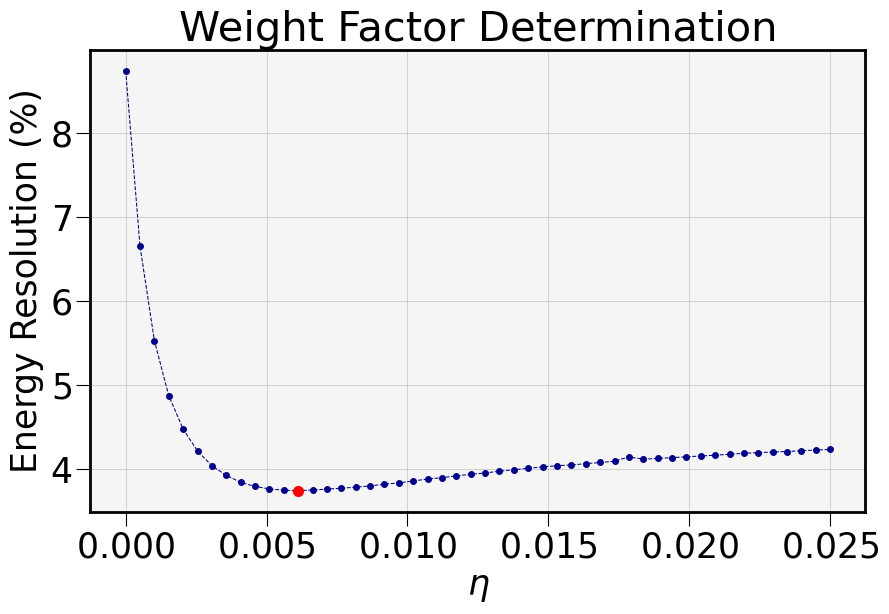

In [40]:
# Find the minimum energy resolution and corresponding eta value
min_index = np.argmin(E_resolution)
Best_eta = eta_values[min_index]
Best_res = E_resolution[min_index]

print(f"The minimum energy resolution is {Best_res:.4f}% at η = {Best_eta:.4f}")

ana_data['High-Rn']['eta_CV'] = Best_eta
# ana_data['Low-Rn']['eta_CV']  = Best_eta

# Plot
plt.figure(figsize=(10, 6))
plt.plot(eta_values, E_resolution, c='darkblue', marker='o', ms=4, ls='--', lw=0.75)
plt.scatter([Best_eta], [Best_res], c='red', s=25, zorder=3)
plt.xlabel('$\\eta$')
plt.ylabel('Energy Resolution (%)')
plt.title('Weight Factor Determination')

plt.gca().set_facecolor('whitesmoke')
plt.grid(True, linestyle='-', linewidth=0.75, alpha=0.5)
plt.show()

## $\lambda$ determination

High-Rn - Initial values:
222Rn: N_1 = 1.0000, μ_1 = 6500.00 PE, σ_1 = 15.69 PE

High-Rn - Fit values:
222Rn: N_1 = (1.1131e+03 ± 1.0703e+01), μ_1 = (6482.51 ± 0.80) PE, σ_1 = (110.27 ± 0.72) PE
222Rn: λ = 0.8624 keV/PE
χ² / ndof = 6.4236


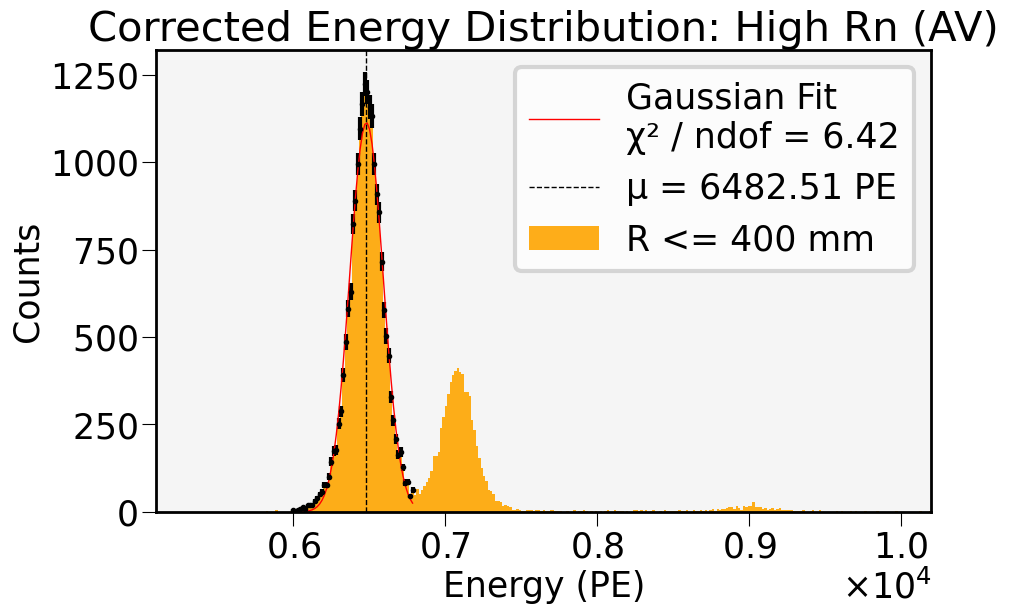

In [41]:
# Global
n_bins  = 1000
rad_lim = 400
E_Rn = 5590.3   # [keV] 222Rn energy peak

# High-Rn info
Rn_data = ana_data['High-Rn']['df']
eta = ana_data['High-Rn']['eta_CV']

# Variables
R = Rn_data['R']
E1_corr = Rn_data['S1e_corr']
E2_corr = Rn_data['S2e_corr']
E_total = E1_corr + (E2_corr * eta)  # Energy estimator

# Masking
rad_mask = (R <= rad_lim)
AV_mask  = ana_data['High-Rn']['AV_mask']
E_mask   = E_total[AV_mask & rad_mask]

# Histogram
E_counts, E_edges = np.histogram(E_mask, bins=n_bins, range=(0, E_total.max()))
E_stat = np.sqrt(E_counts);  E_syst = 0
E_errors = np.sqrt(E_stat**2 + E_syst**2)

bin_width = np.diff(E_edges).mean()

# ----- Gaussian Fit ----- #
# Preliminary
E_min = 6e3;  E_max = 6.8e3
fit_centers, fit_values, fit_errors = ff.prefit_1D(E_edges, E_counts, y_errors=E_errors, x_min=E_min, x_max=E_max)

# Definte the cost function + initial guess
least_squares = LeastSquares(fit_centers, fit_values, fit_errors, ff.gauss_func)
init_guess    = [1, 6500, bin_width]
print(f'High-Rn - Initial values:')
print(f"222Rn: N_1 = {init_guess[0]:.4f}, μ_1 = {init_guess[1]:.2f} PE, σ_1 = {init_guess[2]:.2f} PE")

# Define the Minuit object
m = Minuit(least_squares, A1=init_guess[0], mu1=init_guess[1], sigma1=init_guess[2])

# Apply soft bounds to the parameters
m.limits['mu1'] = (6250, 6750);  m.limits['sigma1'] = (0.5*bin_width, np.inf)

# Minimization process of the cost function and error estimation
m.migrad()
m.hesse()

# Results
popt = m.values;  perr = m.errors
print(f'\nHigh-Rn - Fit values:')
print(f"222Rn: N_1 = ({popt[0]:.4e} ± {perr[0]:.4e}), μ_1 = ({popt[1]:.2f} ± {perr[1]:.2f}) PE, σ_1 = ({popt[2]:.2f} ± {perr[2]:.2f}) PE")

# Lambda value
High_lambda = E_Rn / (popt[1])
print(f"222Rn: λ = {High_lambda:.4f} keV/PE")
ana_data['High-Rn']['lambda_CV'] = High_lambda

# Reduced chi-square
chi2 = m.fval
ndof = len(fit_centers) - m.nfit
print(f"χ² / ndof = {chi2 / ndof:.4f}")

# ----- Plotting ----- #
plt.figure(figsize=(10, 6))

# Data 
plt.bar(E_edges[:-1], E_counts, width=bin_width, align='edge',
        color=pt.hist_colors[2], alpha=0.9, lw=1.0, label=f'R <= {rad_lim} mm')

# Fit
y_fit = ff.gauss_func(fit_centers, *popt)
plt.errorbar(fit_centers, fit_values, yerr=fit_errors, fmt='o', ms=3, c='black', ecolor='black')                                 
plt.plot(fit_centers, y_fit, color="red", lw=1.0, label=f'Gaussian Fit\nχ² / ndof = {chi2 / ndof:.2f}')
plt.axvline(x=popt[1], c='black', alpha=1, ls='--', lw=1.0, label=f'μ = {popt[1]:.2f} PE')

# Styling                      
plt.xlabel('Energy (PE)')
plt.xlim(0.85*E_min, 1.5*E_max)
plt.ylabel('Counts')
# plt.yscale('log')
plt.title(f'Corrected Energy Distribution: High Rn (AV)')
plt.legend(loc='upper right')    
plt.gca().set_facecolor("whitesmoke")

plt.show()

# α-Producing Isotopes

## DT distribution

High-Rn:
Cathode time position = (1347.33 +/- 9.17) μs
Drift velocity = (0.87 +/- 0.01) mm/μs 



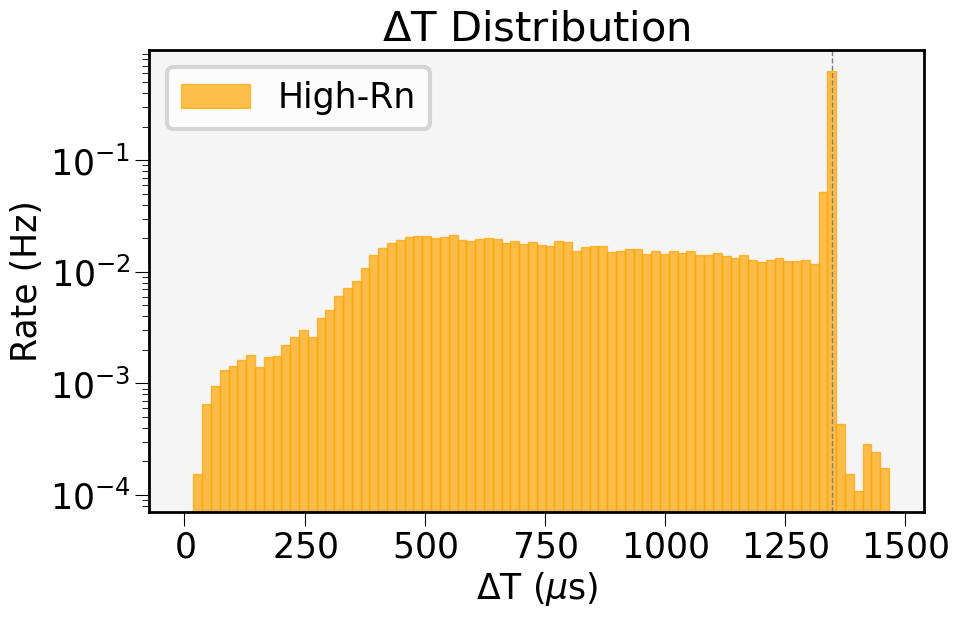

In [44]:
# Store important information
V_drift = {"High-Rn":{}, "Low-Rn":{}}  # Drift velocities
m_DT    = {"High-Rn":{}, "Low-Rn":{}}  # Slopes from linear fit

# Global
n_bins = 80
DT_min = 400                 # Linear fit lower limit

plt.figure(figsize=(10, 6))
color_index = 0              # Histogram color counter

for i, entry in enumerate(ana_data):
    
    Rn_data = ana_data[entry]['df']
    Rn_long = ana_data[entry]['duration_CV']
    
    # Variables
    DT = Rn_data['DT']

    # Histogram: normalized by corrected DAQ data taking time
    DT_counts, DT_edges = np.histogram(DT, bins=n_bins,  range=(0, DT.max()), density=False)
    DT_rate   = DT_counts / Rn_long
    bin_width = np.diff(DT_edges).mean()
    
    # Estimated cathode time position + error
    cath_index   = np.argmax(DT_counts)         # Index of the bin with the highest count
    cath_central = (DT_edges[cath_index] + DT_edges[cath_index + 1]) / 2      # Central value of the bin
    cath_error   = bin_width / 2

    # Drift velocity + error
    drift_vel      = (pt.N100_hei - pt.EL_gap) / cath_central
    drift_error    = drift_vel * (cath_error / cath_central)
    V_drift[entry] = {'CV': drift_vel, 'Error': drift_error}

    print(f'{entry}:')
    print(f'Cathode time position = ({cath_central:.2f} +/- {cath_error:.2f}) μs')
    print(f'Drift velocity = ({drift_vel:.2f} +/- {drift_error:.2f}) mm/μs \n')

    # Plot the normalized histogram + cathode line
    plt.bar(DT_edges[:-1], DT_rate, width=bin_width, align='edge', 
            color=pt.hist_colors[(3*i+2) % len(pt.hist_colors)], ec=pt.hist_colors[(3*i+2) % len(pt.hist_colors)],
            alpha=0.7, lw=1.0 , label=f'{entry}')         
    plt.axvline(x=cath_central, c='gray', ls='--', lw=1)  # Cathode line

    # ----- Linear fit ----- #
    DT_max = ana_data[entry]['DTstop_CV']
    fit_centers, fit_values, fit_errors = ff.prefit_1D(DT_edges, DT_rate, x_min=DT_min, x_max=DT_max)

    popt, pcov = curve_fit(ff.linear_func, fit_centers, fit_values)
    m_DT[entry] = {'CV': popt[0], 'Error': np.sqrt(pcov[0, 0])}

    # Plot fit
    fit_y = ff.linear_func(fit_centers, *popt)
    # plt.plot(fit_centers, fit_y, c='red', ls='--', lw=1.5)

    color_index += 1
        
# Plot
plt.xlabel('$\Delta$T ($\mu$s)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'$\Delta$T Distribution')
plt.legend(loc='upper left')
plt.gca().set_facecolor("whitesmoke")

plt.show()

## Energy Distribution

High-Rn - Initial values:

222Rn: N_1 = 1.00 Hz, μ_1 = 5500.00 keV, σ_1 = 11.70 keV
218Po: N_2 = 1.00 Hz, μ_2 = 6300.00 keV, σ_2 = 11.70 keV
214Po: N_3 = 1.00 Hz, μ_3 = 7750.00 keV, σ_3 = 11.70 keV

High-Rn - Fit values:

222Rn: N_1 = (2.1110e-02 ± 2.0339e-04) Hz, μ_1 = (5590.18 ± 0.69) keV, σ_1 = (94.69 ± 0.63) keV
218Po: N_2 = (7.1517e-03 ± 1.1646e-04) Hz, μ_2 = (6106.32 ± 1.25) keV, σ_2 = (100.42 ± 1.17) keV
214Po: N_3 = (1.9928e-04 ± 1.8450e-05) Hz, μ_3 = (7756.88 ± 10.51) keV, σ_3 = (189.23 ± 15.82) keV
χ² / ndof = 2.4952

Selection total rate = 0.6092 ± 0.0037 Hz
  222Rn: α = 1.0000 ± 0.0101
  218Po: α = 0.3593 ± 0.0050
  214Po: α = 0.0189 ± 0.0010

222Rn selection activity = 0.4420 ± 0.0045 Hz
222Rn activity = 30.8425 ± 4.1041 Hz
222Rn activity = 53.5765 ± 0.8018 Bq / m³
Bi activity: 14.6151% ± 0.8881%


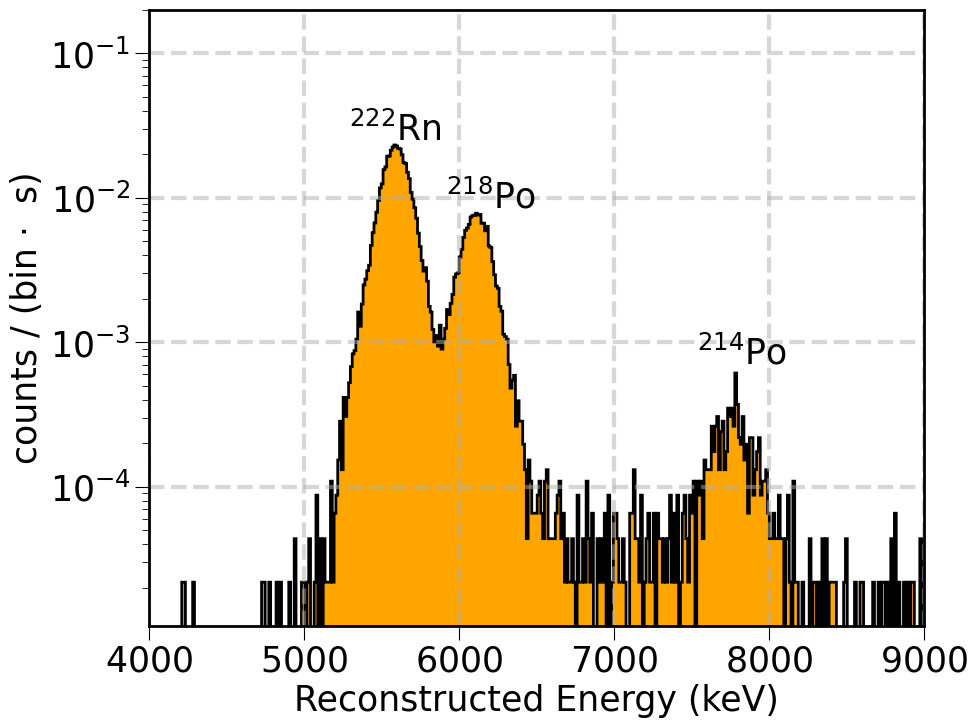

In [57]:
# Global
n_bins  = 1000
rad_lim = [400]  # Radius limits

for i, r_lim in enumerate(rad_lim):

    # High-Rn info
    Rn_data       = ana_data['High-Rn']['df']
    Rn_long       = ana_data['High-Rn']['duration_CV']
    Trigg_evt_CV  = ana_data['High-Rn']['trigg_evt_CV']
    Trigg_evt_err = ana_data['High-Rn']['trigg_evt_err']
    Sel_evt_CV    = ana_data['High-Rn']['sel_evt_CV']  
    Eta_CV        = ana_data['High-Rn']['eta_CV']
    Lambda_CV     = ana_data['High-Rn']['lambda_CV']

    # Variables
    R = Rn_data['R']
    E1_corr = Rn_data['S1e_corr']
    E2_corr = Rn_data['S2e_corr']
    E_total = Lambda_CV * (E1_corr + (E2_corr * Eta_CV))  # Energy estimator

    # Masking
    rad_mask = (R <= r_lim)
    AV_mask  = ana_data['High-Rn']['AV_mask']
    E_mask   = E_total[AV_mask & rad_mask]

    # Histogram: normalized by corrected DAQ data taking time
    E_counts, E_edges = np.histogram(E_mask, bins=n_bins, range=(E_mask.min(), E_mask.max()))
    E_rates  = E_counts / Rn_long;
    E_stat   = np.sqrt(E_counts) / Rn_long;  E_syst = 0
    E_errors = np.sqrt(E_stat**2 + E_syst**2)
    bin_width = np.diff(E_edges).mean()

    # ----- Tri-Gaussian Fit ----- #
    # Preliminary
    E_min = 4.5e3;  E_max = 8.5e3
    fit_centers, fit_values, fit_errors = ff.prefit_1D(E_edges, E_rates, y_errors=E_errors, x_min=E_min, x_max=E_max)

    # Definte the cost function + initial guess
    least_squares = LeastSquares(fit_centers, fit_values, fit_errors, ff.trigauss_func)
    init_guess    = [1, 5500, bin_width, 1, 6300, bin_width, 1, 7750, bin_width]
    print(f'High-Rn - Initial values:\n')
    print(f"222Rn: N_1 = {init_guess[0]:.2f} Hz, μ_1 = {init_guess[1]:.2f} keV, σ_1 = {init_guess[2]:.2f} keV")
    print(f"218Po: N_2 = {init_guess[3]:.2f} Hz, μ_2 = {init_guess[4]:.2f} keV, σ_2 = {init_guess[5]:.2f} keV")
    print(f"214Po: N_3 = {init_guess[6]:.2f} Hz, μ_3 = {init_guess[7]:.2f} keV, σ_3 = {init_guess[8]:.2f} keV\n")

    # Define the Minuit object
    m = Minuit(least_squares,
               A1=init_guess[0], mu1=init_guess[1], sigma1=init_guess[2],
               A2=init_guess[3], mu2=init_guess[4], sigma2=init_guess[5],
               A3=init_guess[6], mu3=init_guess[7], sigma3=init_guess[8])
    
    # Apply soft bounds to the parameters
    m.limits['mu1'] = (5000, 5800);  m.limits['sigma1'] = (0.5*bin_width, np.inf)
    m.limits['mu2'] = (6000, 6600);  m.limits['sigma2'] = (0.5*bin_width, np.inf)
    m.limits['mu3'] = (7500, 8000);  m.limits['sigma3'] = (0.5*bin_width, np.inf)

    # Minimization process of the cost function and error estimation
    m.migrad()
    m.hesse()

    # Results
    popt = m.values;  perr = m.errors
    print(f'High-Rn - Fit values:\n')
    print(f"222Rn: N_1 = ({popt[0]:.4e} ± {perr[0]:.4e}) Hz, μ_1 = ({popt[1]:.2f} ± {perr[1]:.2f}) keV, σ_1 = ({popt[2]:.2f} ± {perr[2]:.2f}) keV")
    print(f"218Po: N_2 = ({popt[3]:.4e} ± {perr[3]:.4e}) Hz, μ_2 = ({popt[4]:.2f} ± {perr[4]:.2f}) keV, σ_2 = ({popt[5]:.2f} ± {perr[5]:.2f}) keV")
    print(f"214Po: N_3 = ({popt[6]:.4e} ± {perr[6]:.4e}) Hz, μ_3 = ({popt[7]:.2f} ± {perr[7]:.2f}) keV, σ_3 = ({popt[8]:.2f} ± {perr[8]:.2f}) keV")

    # Reduced chi-square
    chi2 = m.fval
    ndof = len(fit_centers) - m.nfit
    print(f"χ² / ndof = {chi2 / ndof:.4f}\n")

    # ----- Radon Activity ----- #
    # Compute the integral of the histogram + error ---> it could be multiplying by bin_width but depends on the histogram density
    total_rate_CV  = np.sum(E_rates)                          
    total_rate_err = np.sqrt(np.sum(E_errors**2))
    print(f'Selection total rate = {total_rate_CV:.4f} ± {total_rate_err:.4f} Hz')

    # Compute the integral for each Gaussian and its error
    isotopes = ['222Rn', '218Po', '214Po']
    param_indices = [(0, 1, 2), (3, 4, 5), (6, 7, 8)]
    param_name_list = [['A1', 'mu1', 'sigma1'], ['A2', 'mu2', 'sigma2'], ['A3', 'mu3', 'sigma3']]
    alphas = {"222Rn": {"CV": 0.0, "Error": 0.0}, "218Po": {"CV": 0.0, "Error": 0.0}, "214Po": {"CV": 0.0, "Error": 0.0}}

    for i, isotope in enumerate(isotopes):

        A_index, mu_index, sigma_index = param_indices[i]
        A, mu, sigma = popt[A_index], popt[mu_index], popt[sigma_index]
        param_names  = param_name_list[i]

        integral_CV, integral_err = ff.gauss_int_err(A, mu, sigma, E_mask.min(), E_mask.max(), m, param_names)
        # print(f"Fit rate {isotope}: {integral_CV:.4f} ± {integral_err:.4f} Hz")

        # Compute the proportion of each isotope
        if isotope == '222Rn':
            rate_222_CV = integral_CV;  rate_222_err = integral_err

        alphas[isotope]['CV']    = integral_CV / rate_222_CV
        alphas[isotope]['Error'] = alphas[isotope]['CV'] * np.sqrt((integral_err / integral_CV)**2 + (rate_222_err / rate_222_CV)**2)
        print(f"  {isotope}: α = {alphas[isotope]['CV']:.4f} ± {alphas[isotope]['Error']:.4f}")

    # Compute the selection radon activity
    alphas_sum_CV  = sum(entry["CV"]               for entry in alphas.values())
    alphas_sum_err = np.sqrt(sum(entry["Error"]**2 for entry in alphas.values()))

    Rn_sel_activity_CV  = total_rate_CV / alphas_sum_CV
    Rn_sel_activity_err = Rn_sel_activity_CV * np.sqrt((total_rate_err / total_rate_CV)**2 + (alphas_sum_err / alphas_sum_CV)**2)
    print(f"\n222Rn selection activity = {Rn_sel_activity_CV:.4f} ± {Rn_sel_activity_err:.4f} Hz")

    # Compute the efficiency to rescale the activity
    Mask_evt_CV  = len(E_mask)
    Mask_eff     = Mask_evt_CV / Sel_evt_CV
    Mask_evt_err = np.sqrt(Sel_evt_CV * Mask_eff * (1 - Mask_eff))
    # print(f"Masked events: {Mask_evt_CV:.2f} ± {Mask_evt_err:.2f}")

    ana_eff_CV  = Mask_evt_CV / Trigg_evt_CV
    ana_eff_err = ana_eff_CV * np.sqrt((Mask_evt_err / Mask_evt_CV)**2 + (Trigg_evt_err / Trigg_evt_CV)**2)
    Rn_activity_CV  = Rn_sel_activity_CV / ana_eff_CV                             # Corrected by the efficiency
    Rn_activity_err = Rn_activity_CV * np.sqrt((Rn_sel_activity_err / Rn_sel_activity_CV)**2 + (ana_eff_err / ana_eff_CV)**2)
    print(f"222Rn activity = {Rn_activity_CV:.4f} ± {Rn_activity_err:.4f} Hz")

    # Selection volume
    z_lim_CV  = V_drift['High-Rn']['CV'] * ana_data['High-Rn']['DTstop_CV']  # Maximum drift length
    z_lim_err = z_lim_CV * np.sqrt((V_drift['High-Rn']['Error'] / V_drift['High-Rn']['CV'])**2 + (ana_data['High-Rn']['DTstop_err'] / ana_data['High-Rn']['DTstop_CV'])**2)
    NEXT_vol_CV, NEXT_vol_err = pt.selection_volume(z_lim_CV, z_lim_err, r_lim, 1)            # Assuming nominalr error of 1 mm for the radius

    # Compute the activity in Bq/m³
    Rn_activity_CV  = Rn_activity_CV / (NEXT_vol_CV * 1e-9)
    Rn_activity_err = Rn_activity_CV * np.sqrt((Rn_sel_activity_err / Rn_sel_activity_CV)**2 + (NEXT_vol_err / NEXT_vol_CV)**2)
    print(f"222Rn activity = {Rn_activity_CV:.4f} ± {Rn_activity_err:.4f} Bq / m³")

    # ----- 214Bi in AV ----- #
    Bi_CV  = alphas['214Po']['CV'] / (alphas['218Po']['CV']**2)
    Bi_err = Bi_CV * np.sqrt((alphas['214Po']['Error'] / alphas['214Po']['CV'])**2 + (2 * alphas['218Po']['Error'] / alphas['218Po']['CV'])**2)
    print(f"Bi activity: {Bi_CV:.4%} ± {Bi_err:.4%}")

    # ----- Plotting ----- #
    # plt.figure(figsize=(10, 6))
    
    # Data
    plt.stairs(E_rates, E_edges, fill=True, color=pt.hist_colors[2], alpha=1.0, 
               edgecolor='black', lw=2.0, label=f'R <= {r_lim} mm')
    # plt.bar(E_edges[:-1], E_rates, width=bin_width, align='edge',
    #         color=pt.hist_colors[2], alpha=0.9, lw=1.0, label=f'R <= {r_lim} mm')
    
    # Fit
    y_fit = ff.trigauss_func(fit_centers, *popt)
    # plt.errorbar(fit_centers, fit_values, yerr=fit_errors, fmt='o', ms=2.5, c='black', ecolor='black')                            
    # plt.plot(fit_centers, y_fit, color="red", lw=1.0, label=f"Tri-Gaussian Fit\nχ² / ndof = {chi2 / ndof:.2f}")

    # Styling
    
    # # Annotate isotopes with manual height adjustment
    # manual_heights = [0.024, 0.008, 8e-4]  # Adjust these values as needed for each isotope
    # for idx, isotope in enumerate(isotopes):
    #     mu_idx = param_indices[idx][1]
    #     plt.text(popt[mu_idx], manual_heights[idx], isotope, ha='center', color='black')



    plt.xlabel('Reconstructed Energy (keV)')
    plt.xlim(4e3, 9e3)
    # plt.xlim(E_mask.min(), E_mask.max())
    plt.ylabel('counts / (bin ·  s)')
    y_min = E_rates[E_rates > 0].min()
    y_del = fit_errors[fit_errors > 0].min()
    plt.ylim(y_min-(y_del/2), 0.2)
    # plt.ylim(0, 0.0275)
    plt.yscale('log')
    # plt.title(f'Corrected Energy Distribution: High Rn (AV)')   
    # plt.legend(loc='upper right')    

    plt.text(5290, 0.025, r'$^{222}$Rn', color='black')
    plt.text(5914, 0.0085, r'$^{218}$Po', color='black')
    plt.text(7533, 0.0007, r'$^{214}$Po', color='black')

    # plt.gca().set_facecolor("whitesmoke")
    plt.grid(True)
    plt.savefig(f'/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/temp/Energy_High_Rn_{r_lim}mm_log.pdf.pdf')
    plt.show()